In [2]:
import numpy as np
import pandas as pd
from psycopg2.extras import execute_batch
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import folium
from folium.plugins import HeatMap

## Constants

In [3]:
RIDER_DETOUR_PROBS = [0.3, 0.25, 0.2, 0.1, 0.1, 0.05]
DRIVER_DETOUR_PROBS = [0.3, 0.25, 0.2, 0.1, 0.1, 0.05]
RIDER_RATIO = 0.75
MIN_TRIP_DISTANCE_METERS = 6000
AVG_TRIP_DISTANCE_METERS = 18170
MAX_TRIP_DISTANCE_METERS = 25000

# Rider preferences
RIDER_DETOUR_VALUES = [0, 10, 15, 20, 25]
RIDER_DETOUR_WEIGHTS = [0.05, 0.42, 0.34, 0.11, 0.08]

WALKING_DURATION_VALUES = [5, 10, 15, 20, 25]  
WALKING_DURATION_WEIGHTS = [0.45, 0.36, 0.11, 0.04, 0.04]

RIDERS_PER_REQUEST_VALUES = [1, 2, 3]
RIDERS_PER_REQUEST_WEIGHTS = [0.63, 0.31, 0.06]

# Driver preferences
DRIVER_DETOUR_VALUES = [0, 10, 15, 20, 25]
DRIVER_DETOUR_WEIGHTS = [0.29, 0.37, 0.2, 0.1, 0.04]

DRIVER_CAPACITY_VALUES = [1, 2, 3]
DRIVER_CAPACITY_WEIGHTS = [0.21, 0.30, 0.49]

# Gender preferences
FEMALE_SAME_GENDER_WEIGHTS = [0.92, 0.08]  # [True, False]
MALE_SAME_GENDER_WEIGHTS = [0.58, 0.42]    # [True, False]

DRIVER_GENDER_WEIGHTS = [0.63, 0.37]      # [male, female]
RIDER_GENDER_WEIGHTS = [0.57, 0.53]       # [male, female]

In [4]:
dataset_file_path_sf = "C:/Users/mariam/Downloads/Datasets/New folder/san francisco/Taxi_Trips.csv"
dataset_file_path_ch = "C:/Users/mariam/Downloads/Datasets/New folder/Taxi Trips Chicago 2024/Taxi_Trips_-_2024_20240408.csv"
dataset_file_path_nyc = "C:/Users/mariam/Downloads/Datasets/archive/nyc_taxi_data_2014(1).csv"

In [5]:
columns_to_keep_sf = [
    'start_time_local',
    'end_time_local',
    'pickup_location_latitude',
    'pickup_location_longitude',
    'dropoff_location_latitude',
    'dropoff_location_longitude',
    "fare_time_milliseconds",
    'trip_distance_meters'
]
columns_to_keep_ch = [
    "Trip Start Timestamp",
    "Trip End Timestamp",
    "Pickup Centroid Latitude",
    "Pickup Centroid Longitude",
    "Dropoff Centroid Latitude",
    "Dropoff Centroid Longitude",
    "Trip Seconds",
    "Trip Miles"
]  
columns_to_keep_nyc = {
    "pickup_datetime":"start_time",
    "dropoff_datetime": "end_time",
    "pickup_latitude" : "pickup_latitude",
    "pickup_longitude": "pickup_longitude",
    "dropoff_latitude": "dropoff_latitude",
    "dropoff_longitude": "dropoff_longitude",
    "passenger_count" : "passenger_count",
    "trip_distance": "trip_distance_meters",
}

rename_columns = [
    "start_time",
    "end_time",
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude",
    "trip_seconds",
    "trip_distance_meters"
]

## Read Dataset

### Functions

In [6]:
def load_dataset(file_path, columns_to_keep, rename_columns=None, millisecond_to_second=False, miles_to_meters=False):
    """Load and filter a dataset from CSV file"""
    df = pd.read_csv(file_path)
    df = df[columns_to_keep]
    
    # Create a dictionary mapping old column names to new column names if rename_columns is provided
    # Check if rename_columns is already a dictionary
    if not isinstance(rename_columns, dict):
        # Convert the list to a dictionary
        rename_dict = {old: new for old, new in zip(columns_to_keep, rename_columns)}
    else:
        rename_dict = rename_columns
    
    # Now rename the columns with the dictionary
    df = df.rename(columns=rename_dict)
        
    if millisecond_to_second:
        df['trip_seconds'] = df['trip_seconds'] / 1000
    if miles_to_meters:
        df['trip_distance_meters'] = df['trip_distance_meters'] * 1609.344
    return df

    
def plot_distribution(df, column, x_unit, x_factor=1, lower_quantile=0.01, upper_quantile=0.99, bins=30):
    """
    Plots the distribution of a specified column in a DataFrame,
    focusing on the majority of the values by trimming outliers based on quantiles.
    
    Parameters:
        df (DataFrame): The input dataset.
        column (str): The column to plot.
        lower_quantile (float): Lower quantile for trimming (default 1%).
        upper_quantile (float): Upper quantile for trimming (default 99%).
        bins (int): Number of bins in the histogram.
    """
    # Drop NaN values
    data = df[column].dropna()
    
    # Compute quantile range
    lower_bound = data.quantile(lower_quantile)
    upper_bound = data.quantile(upper_quantile)
    
    # Filter data within quantile range
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.histplot(filtered_data, bins=bins, kde=True, color='skyblue')
    
    plt.title(f'Distribution of {column} (Focused on {lower_quantile*100:.0f}%-{upper_quantile*100:.0f}%)')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1e3)}K'))

    # Format x-axis to show values in 'minutes' instead of 'seconds'
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x * x_factor)} {x_unit}'))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
def analyze_trips_per_day(df, date_column="start_time", lower_quantile=0.1, upper_quantile=0.9):
    """
    Analyze the average trips per day in a dataset.
    
    Parameters:
        df (DataFrame): The input taxi dataset
        date_column (str): The column containing timestamp data
    
    Returns:
        dict: Statistics about trips per day
    """
    # Ensure the date column is datetime type
    if not pd.api.types.is_datetime64_any_dtype(df[date_column]):
        df[date_column] = pd.to_datetime(df[date_column])
    
    # Extract date (without time) for grouping
    df['date'] = df[date_column].dt.date
    
    # Group by date and count trips per day
    # Group by date and count trips per day, then filter to 90th percentile
    trips_per_day = df.groupby('date').size()
    
    lower_bound = trips_per_day.quantile(lower_quantile)
    upper_bound = trips_per_day.quantile(upper_quantile)
    
    filtered_data = trips_per_day[(trips_per_day >= lower_bound) & (trips_per_day <= upper_bound)]
    
    # Calculate statistics
    stats = {
        'average_trips_per_day': trips_per_day.mean(),
        'median_trips_per_day': trips_per_day.median(),
        'min_trips_per_day': trips_per_day.min(),
        'max_trips_per_day': trips_per_day.max(),
        'total_days': len(trips_per_day)
    }
    
    # Plot the distribution of trips per day
    plt.figure(figsize=(12, 6))
    
    # Line plot showing trips over time
    plt.subplot(1, 2, 1)
    filtered_data.plot(kind='line', color='blue')
    plt.title('Trips per Day Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Trips')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Histogram showing distribution of daily trips
    plt.subplot(1, 2, 2)
    sns.histplot(filtered_data, bins=30, kde=True, color='green')
    plt.title('Distribution of Daily Trip Counts')
    plt.xlabel('Number of Trips per Day')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return stats
    
def plot_time_distribution(df, datetime_column='start_time', bins=24, kde=True, 
                          title=None, figsize=(12, 6), color='skyblue'):
    """
    Plot the distribution of times from a datetime column, regardless of date.
    
    Parameters:
        df (DataFrame): The input dataset
        datetime_column (str): The column containing datetime data
        bins (int): Number of bins (24 = hourly bins, 48 = half-hourly, etc.)
        kde (bool): Whether to show kernel density estimate
        title (str, optional): Custom title for the plot
        figsize (tuple): Figure size (width, height)
        color (str): Color for the histogram
        
    Returns:
        matplotlib.figure.Figure: The figure object
    """
    # Ensure the column is datetime type
    if not pd.api.types.is_datetime64_any_dtype(df[datetime_column]):
        df = df.copy()
        df[datetime_column] = pd.to_datetime(df[datetime_column])
    
    # Extract time components
    hours = df[datetime_column].dt.hour
    minutes = df[datetime_column].dt.minute
    seconds = df[datetime_column].dt.second
    
    # Convert to decimal hours (e.g., 13:30:00 becomes 13.5)
    time_decimal = hours + minutes/60 + seconds/3600
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot histogram with KDE
    sns.histplot(time_decimal, bins=bins, kde=kde, color=color, ax=ax)
    
    # Customize x-axis to show hours
    ax.set_xticks(range(0, 24, 2))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(0, 24, 2)])
    ax.set_xlim(0, 24)
    
    # Set labels
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f'Distribution of Trip Start Times')
    ax.set_xlabel('Time of Day')
    ax.set_ylabel('Frequency')
    
    # Add grid for readability
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Show current time ranges
    morning_mask = (time_decimal >= 6) & (time_decimal < 12)
    afternoon_mask = (time_decimal >= 12) & (time_decimal < 18)
    evening_mask = (time_decimal >= 18) & (time_decimal < 22)
    night_mask = (time_decimal >= 22) | (time_decimal < 6)
    
    total_trips = len(time_decimal)
    
    # Add text annotations for time period statistics
    stats_text = (
        f"Morning (6am-12pm): {morning_mask.sum()} trips ({morning_mask.sum()/total_trips:.1%})\n"
        f"Afternoon (12pm-6pm): {afternoon_mask.sum()} trips ({afternoon_mask.sum()/total_trips:.1%})\n"
        f"Evening (6pm-10pm): {evening_mask.sum()} trips ({evening_mask.sum()/total_trips:.1%})\n"
        f"Night (10pm-6am): {night_mask.sum()} trips ({night_mask.sum()/total_trips:.1%})"
    )
    
    # Add text box with stats
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    return fig

# Example usage:
# plot_time_distribution(dataset_sf)


In [49]:
def filter_invalid_columns(df):
    """
    Filter out rows with null or invalid values in any of the coordinate columns.
    
    Parameters:
        df: DataFrame containing taxi trip data
    
    Returns:
        DataFrame with all rows containing null or invalid coordinates removed
    """
    # Count total rows before filtering
    total_rows = len(df)
    
    # Create a mask for rows with any null coordinates
    null_mask = (
        df['pickup_latitude'].isnull() | 
        df['pickup_longitude'].isnull() | 
        df['dropoff_latitude'].isnull() | 
        df['dropoff_longitude'].isnull()
    )
    
    # Create a mask for rows with invalid coordinate ranges
    invalid_mask = (
        (df['pickup_latitude'] >=  37.8324) | (df['pickup_latitude'] <= 37.7083) |
        (df['pickup_longitude'] >= -122.3549) | (df['pickup_longitude'] <= -122.5136) |
        (df['dropoff_latitude'] >=  37.8324) | (df['dropoff_latitude'] <= 37.7083) |
        (df['dropoff_longitude'] >= -122.3549) | (df['dropoff_longitude'] <= -122.5136)
    )
    # def is_in_sf(lat, lng):
    # """Check if coordinates are within San Francisco city limits (approximate)"""
    # return (37.7083 <= lat <= 37.8324 and 
    #         -122.5136 <= lng <= -122.3549)
    # Count rows with null coordinates
    null_rows = null_mask.sum()
    
    # Count rows with invalid coordinates
    invalid_rows = invalid_mask.sum()
    
    # Combined mask for all problematic rows
    problem_mask = null_mask | invalid_mask
    
    # Filter the dataframe to keep only rows with valid coordinates
    filtered_df = df[~problem_mask].copy()
    
    # Print summary
    print(f"Total rows: {total_rows}")
    print(f"Rows with null coordinates: {null_rows} ({null_rows/total_rows:.2%})")
    print(f"Rows with invalid coordinate ranges: {invalid_rows} ({invalid_rows/total_rows:.2%})")
    print(f"Total problematic rows: {problem_mask.sum()} ({problem_mask.sum()/total_rows:.2%})")
    print(f"Rows after filtering: {len(filtered_df)} ({len(filtered_df)/total_rows:.2%})")
    
    return filtered_df
# def filter_invalid_columns(df):
#     """
#     Filter out rows with null values in any of the coordinate columns.
    
#     Parameters:
#         df: DataFrame containing taxi trip data
    
#     Returns:
#         DataFrame with all rows containing null coordinates removed
#     """
#     # Count total rows before filtering
#     total_rows = len(df)
    
#     # Create a mask for rows with any null coordinates
#     null_mask = (
#         df['pickup_latitude'].isnull() | 
#         df['pickup_longitude'].isnull() | 
#         df['dropoff_latitude'].isnull() | 
#         df['dropoff_longitude'].isnull()
#     )
    
#     # Count rows with null coordinates
#     null_rows = null_mask.sum()
    
#     # Filter the dataframe to keep only rows with complete coordinates
#     filtered_df = df[~null_mask].copy()
    
#     # Print summary
#     print(f"Total rows: {total_rows}")
#     print(f"Rows with null coordinates: {null_rows} ({null_rows/total_rows:.2%})")
#     print(f"Rows after filtering: {len(filtered_df)} ({len(filtered_df)/total_rows:.2%})")
    
#     return filtered_df

In [8]:

def plot_pickup_dropoff_map(df, city_name, sample_size=10000):
    """
    Creates an interactive map showing pickup and dropoff locations with heatmap.
    
    Parameters:
        df: DataFrame containing the taxi trip data
        city_name: Name of the city for the map title
        sample_size: Number of points to sample (for better performance)
    """
    # Sample data if it's too large
    if len(df) > sample_size:
        df_sample = df.sample(sample_size, random_state=42)
    else:
        df_sample = df
    
    # Calculate center of the map
    center_lat = df_sample['pickup_latitude'].mean()
    center_lon = df_sample['pickup_longitude'].mean()
    
    # Create a base map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
    
    # Add title
    title_html = f'<h3 align="center" style="font-size:16px"><b>{city_name} Taxi Trip Data</b></h3>'
    m.get_root().html.add_child(folium.Element(title_html))
    
    # Create feature groups for pickups and dropoffs
    pickup_group = folium.FeatureGroup(name='Pickup Locations')
    dropoff_group = folium.FeatureGroup(name='Dropoff Locations')
    
    # Add pickup points heatmap
    pickup_data = [[row['pickup_latitude'], row['pickup_longitude']] for _, row in df_sample.iterrows()]
    HeatMap(pickup_data, radius=15, gradient={0.2: 'blue', 0.5: 'lime', 0.8: 'red'}).add_to(pickup_group)
    
    # Add dropoff points heatmap
    dropoff_data = [[row['dropoff_latitude'], row['dropoff_longitude']] for _, row in df_sample.iterrows()]
    HeatMap(dropoff_data, radius=15, gradient={0.2: 'green', 0.5: 'purple', 0.8: 'orange'}).add_to(dropoff_group)
    
    # Add the feature groups to the map
    pickup_group.add_to(m)
    dropoff_group.add_to(m)
    
    # Add layer control to toggle between pickup and dropoff views
    folium.LayerControl().add_to(m)
    
    return m


### San Francisco Dataset

C:\Users\mariam\AppData\Local\Temp\ipykernel_17124\2281456039.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Total rows: 4129083
Rows with null coordinates: 27524 (0.67%)
Rows with invalid coordinate ranges: 1414251 (34.25%)
Total problematic rows: 1432791 (34.70%)
Rows after filtering: 2696292 (65.30%)
2696292 rows


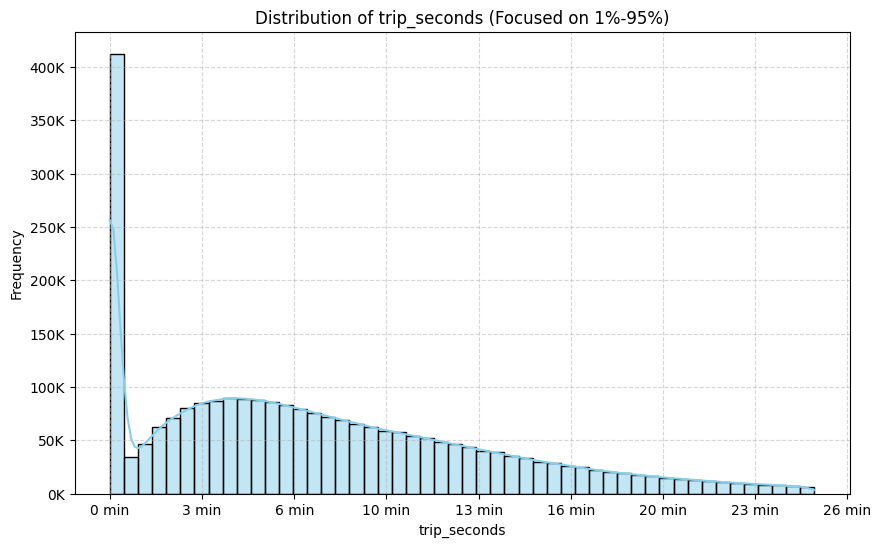

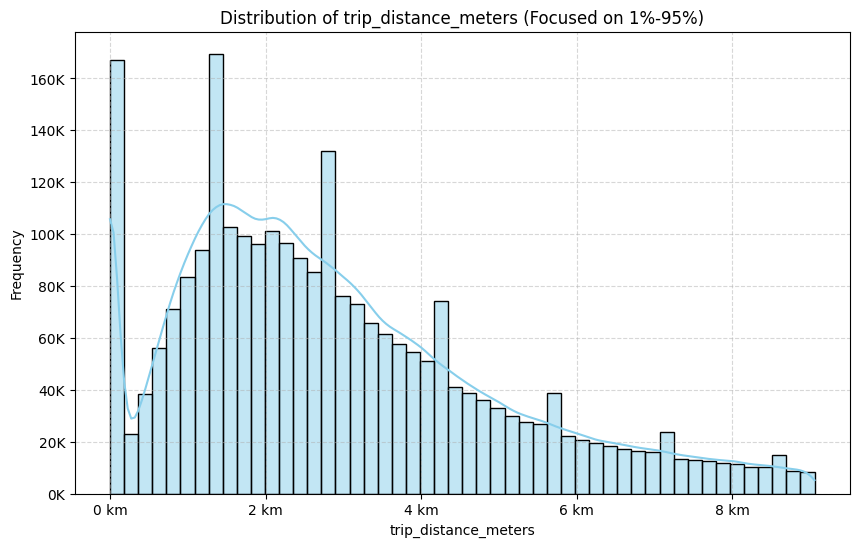

,start_time,end_time,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_seconds,trip_distance_meters
1,2023/01/23 06:37:21 AM,2023/01/23 06:49:34 AM,37.794,-122.396,37.776,-122.394,733.248,2735.8848
4,2023/01/23 06:37:21 AM,2023/01/23 06:49:34 AM,37.794,-122.396,37.776,-122.394,733.248,2735.8848
7,2023/01/23 06:37:33 AM,2023/01/23 06:55:00 AM,37.775,-122.428,37.789,-122.423,245.000,2896.2000
8,2023/10/21 08:14:16 PM,2023/10/21 08:20:51 PM,37.750,-122.433,37.751,-122.434,394.599,1287.5000
11,2023/10/21 08:14:29 PM,2023/10/21 08:31:00 PM,37.792,-122.392,37.798,-122.415,318.000,3588.0700


In [50]:
dataset_sf = load_dataset(dataset_file_path_sf, columns_to_keep_sf,rename_columns, millisecond_to_second=True)
dataset_sf = filter_invalid_columns(dataset_sf)
print(dataset_sf.shape[0], "rows")
plot_distribution(dataset_sf, "trip_seconds",x_factor=1/60,x_unit="min", upper_quantile=0.95, bins=50)
plot_distribution(dataset_sf, "trip_distance_meters",x_factor=1/1000, x_unit="km", upper_quantile=0.95, bins=50)


# print(dataset_sf.describe())
dataset_sf.head()


In [16]:
sf_long_trips = ((dataset_sf['trip_distance_meters'] > 20000) & (dataset_sf['trip_distance_meters'] < 36000)).sum()
sf_percentage = (sf_long_trips / len(dataset_sf)) * 100
print(f"Percentage of long trips in San Francisco dataset: {sf_percentage:.2f}% ({sf_long_trips} out of {len(dataset_sf)})")

Percentage of long trips in San Francisco dataset: 18.92% (781335 out of 4129083)


C:\Users\mariam\AppData\Local\Temp\ipykernel_12920\3732638317.py:73: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_column] = pd.to_datetime(df[date_column])


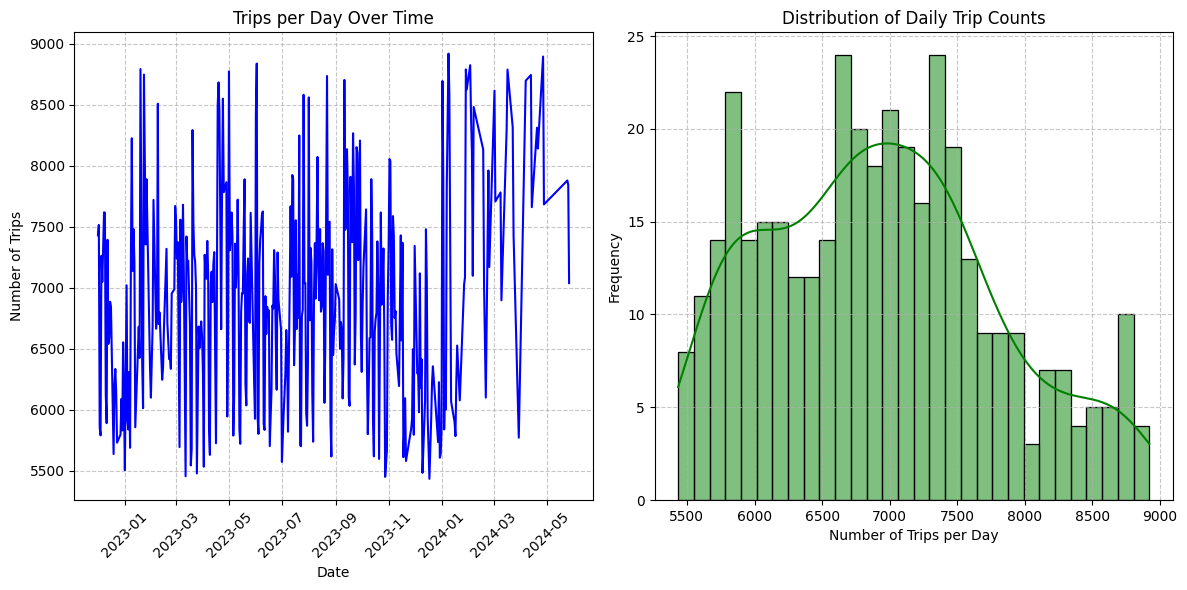

{'average_trips_per_day': 7534.82299270073,
 'median_trips_per_day': 7050.5,
 'min_trips_per_day': 3142,
 'max_trips_per_day': 16096,
 'total_days': 548}

In [10]:
analyze_trips_per_day(dataset_sf, date_column="start_time", lower_quantile=0.1, upper_quantile=0.8)

In [ ]:
sf_map = plot_pickup_dropoff_map(dataset_sf, "San Francisco")
sf_map

### Chicago Dataset

865247 rows


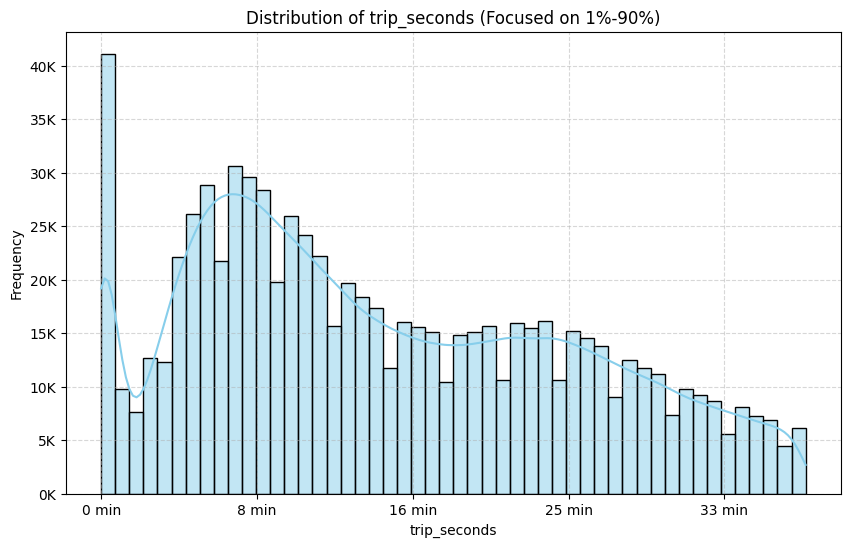

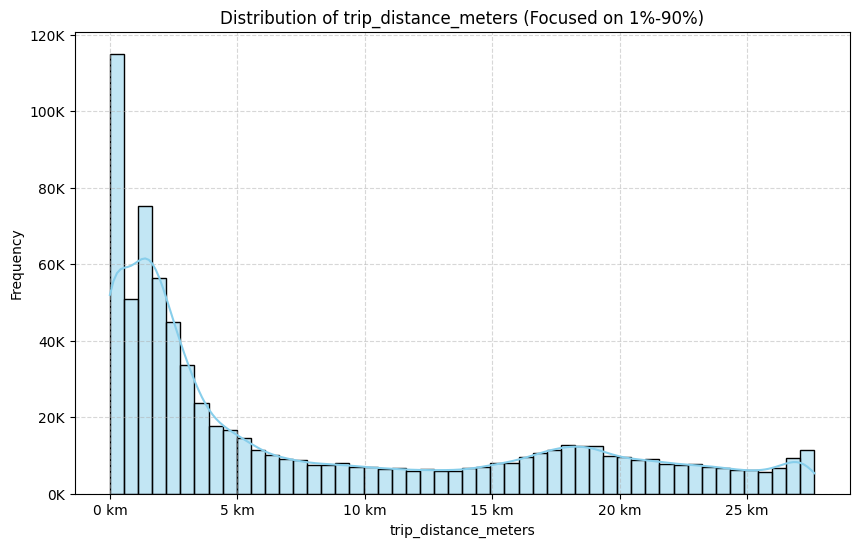

,start_time,end_time,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_seconds,trip_distance_meters
0,03/01/2024 12:00:00 AM,03/01/2024 12:00:00 AM,41.899602,-87.633308,41.899602,-87.633308,15.0,144.84096
1,03/01/2024 12:00:00 AM,03/01/2024 12:15:00 AM,41.901207,-87.676356,41.899602,-87.633308,900.0,4828.03200
2,03/01/2024 12:00:00 AM,03/01/2024 12:00:00 AM,41.792592,-87.769615,NaN,NaN,711.0,9398.56896
3,03/01/2024 12:00:00 AM,03/01/2024 12:30:00 AM,41.980264,-87.913625,41.965812,-87.655879,1770.0,21500.83584
4,03/01/2024 12:00:00 AM,03/01/2024 12:15:00 AM,41.899602,-87.633308,41.965812,-87.655879,849.0,9865.27872


In [ ]:
dataset_ch = load_dataset(dataset_file_path_ch, columns_to_keep_ch,rename_columns, miles_to_meters=True)
dataset_ch = filter_invalid_columns(dataset_ch)
print(dataset_ch.shape[0], "rows")
plot_distribution(dataset_ch, "trip_seconds",x_factor=1/60,x_unit="min",upper_quantile=0.9, bins=50)
plot_distribution(dataset_ch, "trip_distance_meters",x_factor=1/1000, x_unit="km", upper_quantile=0.9, bins=50)
dataset_ch.head()

In [ ]:
analyze_trips_per_day(dataset_ch, date_column="start_time", lower_quantile=0.1, upper_quantile=0.8)

In [ ]:
ch_map = plot_pickup_dropoff_map(dataset_ch, "Chicago")
ch_map

### NYC Dataset

C:\Users\mariam\AppData\Local\Temp\ipykernel_23712\2196181966.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


14999999 rows


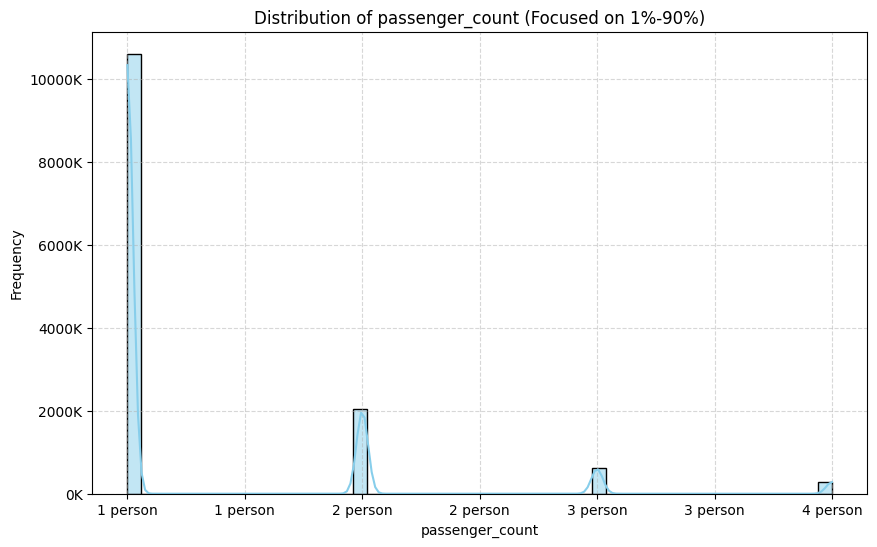

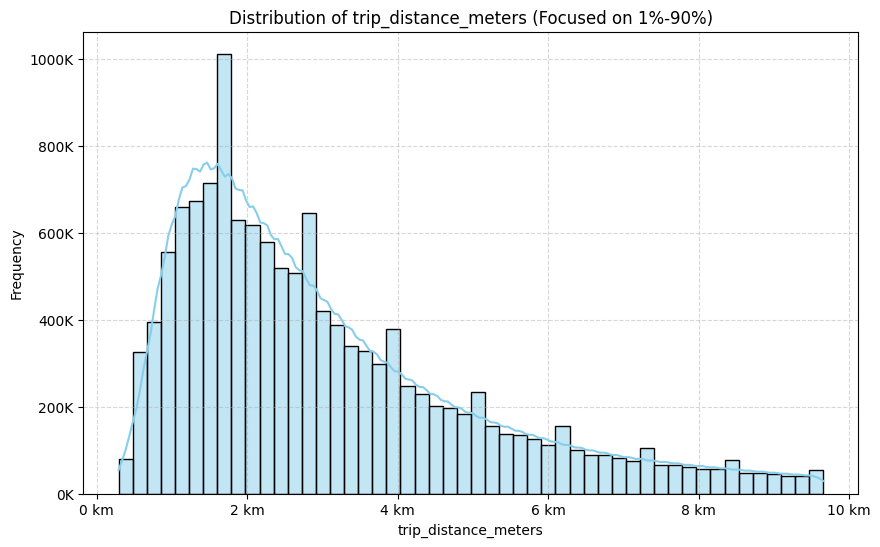

,start_time,end_time,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,trip_distance_meters
0,2014-01-09 20:45:25,2014-01-09 20:52:31,40.736828,-73.994770,40.731790,-73.982227,1,1126.5408
1,2014-01-09 20:46:12,2014-01-09 20:55:12,40.773382,-73.982392,40.763995,-73.960449,1,2253.0816
2,2014-01-09 20:44:47,2014-01-09 20:59:46,40.739406,-73.988570,40.765217,-73.986626,2,3701.4912
3,2014-01-09 20:44:57,2014-01-09 20:51:40,40.770464,-73.960213,40.777050,-73.979863,1,2735.8848
4,2014-01-09 20:47:09,2014-01-09 20:53:32,40.717248,-73.995371,40.720524,-73.984367,1,1448.4096


In [ ]:
dataset_nyc = load_dataset(dataset_file_path_nyc, list(columns_to_keep_nyc.keys()),columns_to_keep_nyc,miles_to_meters=True)
dataset_nyc = filter_invalid_columns(dataset_nyc)
print(dataset_nyc.shape[0], "rows")
plot_distribution(dataset_nyc, "passenger_count",x_unit="person",upper_quantile=0.9, bins=50)
plot_distribution(dataset_nyc, "trip_distance_meters",x_factor=1/1000, x_unit="km", upper_quantile=0.9, bins=50)
dataset_nyc.head()


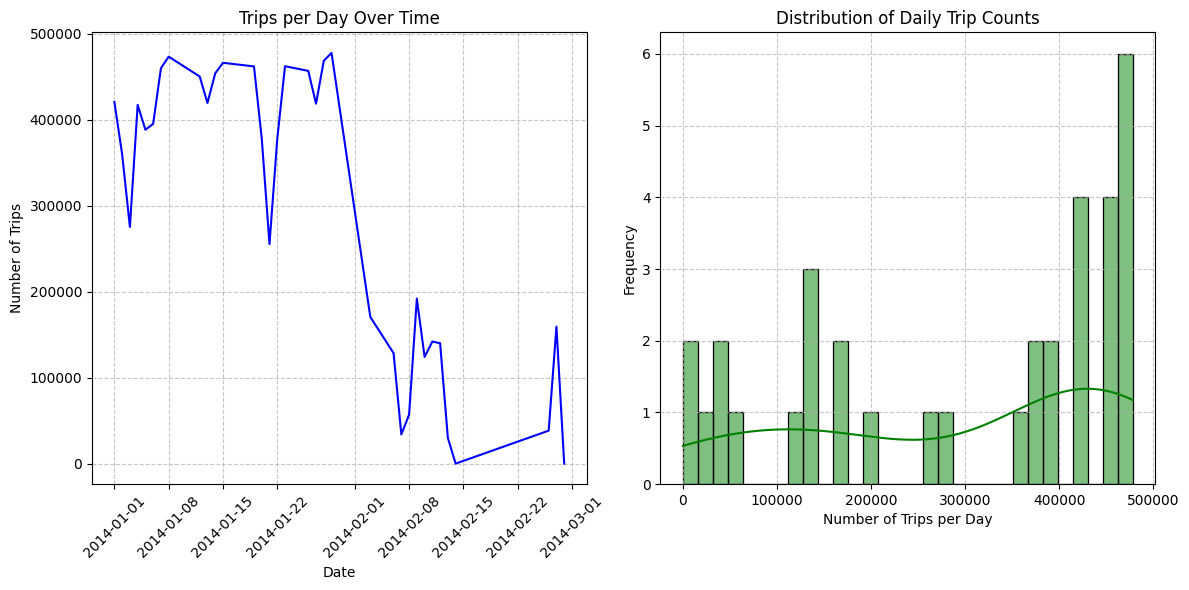

{'average_trips_per_day': 306122.4285714286,
 'median_trips_per_day': 395445.0,
 'min_trips_per_day': 4,
 'max_trips_per_day': 530551,
 'total_days': 49}

In [ ]:
analyze_trips_per_day(dataset_nyc, date_column="start_time", lower_quantile=0.1, upper_quantile=0.8)

In [ ]:
nyc_map = plot_pickup_dropoff_map(dataset_nyc, "New York City")
nyc_map

## Data filtration

### create samples

#### distance distribution

In [17]:
from typing import List, Tuple

def create_targeted_sample(df: pd.DataFrame, 
                          column_name: str,
                          sample_size: int = 1000,
                          target_mean: float = AVG_TRIP_DISTANCE_METERS,
                          target_range_pct: float = 0.75,
                          range_tolerance: float = 0.2,
                          min_value: float = MIN_TRIP_DISTANCE_METERS,
                          max_value: float = MAX_TRIP_DISTANCE_METERS) -> pd.DataFrame:
    """
    Create a sample with specific distribution requirements.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Source dataframe
    column_name : str
        Column name to control distribution for
    sample_size : int
        Desired sample size (default: 1000)
    target_mean : float
        Target mean value for the distribution (default: 22000)
    target_range_pct : float
        Percentage of rows that should be around target_mean (default: 0.85)
    range_tolerance : float
        Tolerance range around target_mean as percentage (default: 0.1 = 10%)
    min_value : float, optional
        Minimum allowed value in the sample (default: None)
    max_value : float, optional
        Maximum allowed value in the sample (default: None)
    
    Returns:
    --------
    pd.DataFrame
        Sampled dataframe with desired distribution
    """
    
    # Apply min/max constraints to the dataframe first
    filtered_df = df.copy()
    if min_value is not None:
        filtered_df = filtered_df[filtered_df[column_name] >= min_value]
    if max_value is not None:
        filtered_df = filtered_df[filtered_df[column_name] <= max_value]
    
    if len(filtered_df) == 0:
        raise ValueError(f"No data available after applying min/max constraints (min: {min_value}, max: {max_value})")
    
    print(f"Data after min/max filtering: {len(filtered_df)} rows (originally {len(df)})")
    
    # Calculate range boundaries
    range_lower = target_mean * (1 - range_tolerance)
    range_upper = target_mean * (1 + range_tolerance)
    
    # Split data into two groups
    in_range_mask = (filtered_df[column_name] >= range_lower) & (filtered_df[column_name] <= range_upper)
    in_range_df = filtered_df[in_range_mask]
    out_range_df = filtered_df[~in_range_mask]
    
    # Calculate sample sizes for each group
    target_range_size = int(sample_size * target_range_pct)
    normal_dist_size = sample_size - target_range_size
    
    print(f"Target range: {range_lower:.0f} - {range_upper:.0f}")
    if min_value is not None or max_value is not None:
        print(f"Value constraints: min={min_value}, max={max_value}")
    print(f"Available in-range rows: {len(in_range_df)}")
    print(f"Available out-range rows: {len(out_range_df)}")
    print(f"Sampling {target_range_size} from range, {normal_dist_size} from normal distribution")
    
    samples = []
    
    # Sample from target range
    if len(in_range_df) >= target_range_size:
        range_sample = in_range_df.sample(n=target_range_size, random_state=42)
        samples.append(range_sample)
        print(f"✓ Successfully sampled {target_range_size} rows from target range")
    else:
        # If not enough data in range, take all available and adjust
        samples.append(in_range_df)
        remaining_needed = target_range_size - len(in_range_df)
        normal_dist_size += remaining_needed
        print(f"⚠ Only {len(in_range_df)} rows available in range, adjusting normal distribution sample")
    
    # Sample from normal distribution around target mean
    if normal_dist_size > 0 and len(out_range_df) > 0:
        # Weight sampling by proximity to normal distribution around target_mean
        distances = np.abs(out_range_df[column_name] - target_mean)
        # Convert distances to weights (closer = higher weight)
        weights = 1 / (1 + distances / target_mean)  # Normalize by target_mean
        weights = weights / weights.sum()  # Normalize to probabilities
        
        if len(out_range_df) >= normal_dist_size:
            normal_sample = out_range_df.sample(n=normal_dist_size, 
                                              weights=weights, 
                                              random_state=42)
            samples.append(normal_sample)
            print(f"✓ Successfully sampled {normal_dist_size} rows for normal distribution")
        else:
            samples.append(out_range_df)
            print(f"⚠ Only {len(out_range_df)} rows available outside range")
    
    # Combine samples
    if samples:
        final_sample = pd.concat(samples, ignore_index=True)
        
        # Shuffle the final sample
        final_sample = final_sample.sample(frac=1, random_state=42).reset_index(drop=True)
        
        # Print statistics
        print_sample_stats(final_sample, column_name, target_mean, range_lower, range_upper)
        
        return final_sample
    else:
        raise ValueError("No suitable data found for sampling")


def print_sample_stats(sample_df: pd.DataFrame, 
                      column_name: str, 
                      target_mean: float,
                      range_lower: float, 
                      range_upper: float):
    """Print statistics about the created sample."""
    
    actual_mean = sample_df[column_name].mean()
    in_range_count = len(sample_df[(sample_df[column_name] >= range_lower) & 
                                  (sample_df[column_name] <= range_upper)])
    in_range_pct = in_range_count / len(sample_df) * 100
    
    print(f"\n📊 Sample Statistics:")
    print(f"Total sample size: {len(sample_df)}")
    print(f"Actual mean: {actual_mean:.2f} (target: {target_mean})")
    print(f"In target range: {in_range_count} ({in_range_pct:.1f}%)")
    print(f"Standard deviation: {sample_df[column_name].std():.2f}")
    print(f"Min value: {sample_df[column_name].min()}")
    print(f"Max value: {sample_df[column_name].max()}")


def create_multiple_samples(df: pd.DataFrame,
                           column_name: str,
                           num_samples: int = 5,
                           **kwargs) -> List[pd.DataFrame]:
    """
    Create multiple samples with the same distribution requirements.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Source dataframe
    column_name : str
        Column name to control distribution for
    num_samples : int
        Number of samples to create
    **kwargs
        Additional arguments passed to create_targeted_sample
    
    Returns:
    --------
    List[pd.DataFrame]
        List of sampled dataframes
    """
    
    samples = []
    for i in range(num_samples):
        print(f"\n🎯 Creating sample {i+1}/{num_samples}")
        print("=" * 50)
        
        # Use different random state for each sample
        sample = create_targeted_sample(df, column_name, **kwargs)
        
        # Update random state for next iteration
        np.random.seed(42 + i)
        
        samples.append(sample)
    
    return samples

In [19]:
def meters_to_minutes(distance_meters, avg_speed_kmh=26):
    """
    Convert distance in meters to time in minutes based on average speed (default SF ≈24 km/h).
    """
    if avg_speed_kmh <= 0:
        raise ValueError("Average speed must be > 0.")
    time_minutes = (distance_meters / 1000) / avg_speed_kmh * 60
    return time_minutes

def normalize_sample_dates(df, target_date="2025-09-15"):
    """
    Normalize all dates in a sample to a specific target date while preserving time differences.
    Returns dates in format "YYYY-MM-DD HH:MM:SS.microsec+00"
    
    Parameters:
        df (DataFrame): DataFrame containing start_time and end_time columns
        target_date (str): Target date in format YYYY-MM-DD        
    Returns:
        DataFrame: Copy of df with normalized dates
    """
    
    df = df.copy()
    
    # Convert to datetime if needed
    for col in ['start_time', 'end_time']:
        if not pd.api.types.is_datetime64_any_dtype(df[col]):
            df[col] = pd.to_datetime(df[col])
    
    # Create target date as datetime
    target_dt = pd.to_datetime(target_date)
    
    # Extract time components to preserve
    df['start_time_hour'] = df['start_time'].dt.hour
    df['start_time_minute'] = df['start_time'].dt.minute
    df['start_time_second'] = df['start_time'].dt.second
    df['start_time_microsecond'] = df['start_time'].dt.microsecond
    
    # Calculate time difference between start and end in seconds
    # df['trip_seconds'] = max((df['end_time'] - df['start_time']).dt.total_seconds() + 60*10, meters_to_minutes(df['trip_distance_meters'])* 60)

    df['trip_seconds'] = np.maximum(
        (df['end_time'] - df['start_time']).dt.total_seconds(), 
        meters_to_minutes(df['trip_distance_meters']) * 60
    )
    # Create new start time with target date
    df['start_time'] = df.apply(
        lambda row: target_dt.replace(
            hour=row['start_time_hour'], 
            minute=row['start_time_minute'], 
            second=row['start_time_second'],
            microsecond=row['start_time_microsecond'] if row['start_time_microsecond'] > 0 else 243632
        ), 
        axis=1
    )
    
    # Create new end time
    # Add the original time difference to new start time
    df['end_time'] = df.apply(
        lambda row: row['start_time'] + pd.Timedelta(seconds=row['trip_seconds']),
        axis=1
    )
    
    # Convert to ISO format with timezone
    df['start_time'] = df['start_time'].apply(
        lambda dt: dt.strftime("%Y-%m-%d %H:%M:%S.%f")[:-3] + "+00"
    )
    
    df['end_time'] = df['end_time'].apply(
        lambda dt: dt.strftime("%Y-%m-%d %H:%M:%S.%f")[:-3] + "+00"
    )
    
    # Drop temporary columns
    df = df.drop(columns=[col for col in df.columns if col.endswith(('_hour', '_minute', '_second', '_microsecond'))], 
                errors='ignore')
    
    return df
# def normalize_sample_dates(df, target_date="2025-09-15"):
#     """
#     Normalize all dates in a sample to a specific target date while preserving time differences.
    
#     Parameters:
#         df (DataFrame): DataFrame containing start_time and end_time columns
#         target_date (str): Target date in format YYYY-MM-DD        
#     Returns:
#         DataFrame: Copy of df with normalized dates
#     """
    
#     df = df.copy()
    
#     # Convert to datetime if needed
#     for col in ['start_time', 'end_time']:
#         if not pd.api.types.is_datetime64_any_dtype(df[col]):
#             df[col] = pd.to_datetime(df[col])
    
#     # Create target date as datetime
#     target_dt = pd.to_datetime(target_date)
    
#     # Extract time components to preserve
#     df['start_time_hour'] = df['start_time'].dt.hour
#     df['start_time_minute'] = df['start_time'].dt.minute
#     df['start_time_second'] = df['start_time'].dt.second
    

#     # Calculate time difference between start and end in minutes
#     df['trip_seconds'] = (df['end_time'] - df['start_time']).dt.total_seconds() + 60*
  
    
#     # Create new start time with target date
#     df['start_time'] = df.apply(
#         lambda row: target_dt.replace(
#             hour=row['start_time_hour'], 
#             minute=row['start_time_minute'], 
#             second=row['start_time_second']
#         ), 
#         axis=1
#     )
    
#     # Create new end time
#     # Add the original time difference to new start time
#     df['end_time'] = df.apply(
#         lambda row: row['start_time'] + pd.Timedelta(seconds=row['trip_seconds']),
#         axis=1
#     )
    
#     # Drop temporary columns
#     df = df.drop(columns=[col for col in df.columns if col.endswith(('_hour', '_minute', '_second', '_diff_minutes'))], 
#                 errors='ignore')
    
#     return df

#### time and distance distribution

In [50]:
def create_combined_sample(df, sample_size=1000, 
                          distance_column="trip_distance_meters",
                          time_column="start_time",
                          target_mean_distance=22000,
                          distance_weight=0.6,  # How much to prioritize distance (0-1)
                          time_weight=0.4,      # How much to prioritize time (0-1)
                          morning_peak=(7, 10),  # Morning rush hour
                          evening_peak=(16, 19), # Evening rush hour
                          min_value=None,
                          max_value=None,
                          random_state=42):
    """
    Create a sample with both distance and time distribution requirements.
    
    Parameters:
        df: DataFrame containing trip data
        sample_size: Number of rows in the sample
        distance_column: Column name for trip distance
        time_column: Column name for start time
        target_mean_distance: Target mean distance for the sample
        distance_weight: Weight for distance in combined score (0-1)
        time_weight: Weight for time in combined score (0-1)
        morning_peak, evening_peak: Rush hour intervals
        min_value, max_value: Min/max values for distance
        random_state: Random seed
        
    Returns:
        DataFrame with specified distribution characteristics
    """
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Apply min/max constraints to distance
    if min_value is not None:
        df = df[df[distance_column] >= min_value]
    if max_value is not None:
        df = df[df[distance_column] <= max_value]
    
    # Ensure time column is datetime
    if not pd.api.types.is_datetime64_any_dtype(df[time_column]):
        df[time_column] = pd.to_datetime(df[time_column])
    
    # Extract hour
    df['hour'] = df[time_column].dt.hour
    
    # Calculate distance weight: higher for values closer to target
    df['distance_score'] = 1 / (1 + np.abs(df[distance_column] - target_mean_distance) / target_mean_distance)
    
    # Calculate time weight: higher for rush hours
    def rush_hour_score(hour):
        # Morning rush
        if morning_peak[0] <= hour < morning_peak[1]:
            return 1.0
        # Evening rush
        elif evening_peak[0] <= hour < evening_peak[1]:
            return 1.0
        # Mid-day (moderate traffic)
        elif 11 <= hour < 15:
            return 0.5
        # Early morning or late night (low traffic)
        else:
            return 0.2
    
    df['time_score'] = df['hour'].apply(rush_hour_score)
    
    # Combine scores with weights
    df['combined_score'] = (df['distance_score'] * distance_weight + 
                           df['time_score'] * time_weight)
    
    # Sample based on combined score
    sample = df.sample(n=min(sample_size, len(df)), 
                      weights='combined_score', 
                      random_state=random_state)
    
    # Remove helper columns
    sample = sample.drop(columns=['hour', 'distance_score', 'time_score', 'combined_score'])
    
    # Print statistics
    print(f"\n📊 Combined Sample Statistics:")
    print(f"Total sample size: {len(sample)}")
    print(f"Mean distance: {sample[distance_column].mean():.2f} (target: {target_mean_distance})")
    
    # Calculate rush hour percentages
    if pd.api.types.is_datetime64_any_dtype(sample[time_column]):
        sample_hours = sample[time_column].dt.hour
        morning_pct = ((sample_hours >= morning_peak[0]) & 
                       (sample_hours < morning_peak[1])).mean() * 100
        evening_pct = ((sample_hours >= evening_peak[0]) & 
                       (sample_hours < evening_peak[1])).mean() * 100
        
        print(f"Morning rush hour trips: {morning_pct:.1f}%")
        print(f"Evening rush hour trips: {evening_pct:.1f}%")
    
    return sample

In [60]:
def create_targeted_sample(df: pd.DataFrame, 
                          column_name: str,
                          sample_size: int = 1000,
                          target_mean: float =  AVG_TRIP_DISTANCE_METERS,
                          target_range_pct: float = 0.75,
                          range_tolerance: float = 0.2,
                          min_value: float = MIN_TRIP_DISTANCE_METERS,
                          max_value: float = MAX_TRIP_DISTANCE_METERS,
                          time_column: str = "start_time",
                          rush_hours: List[Tuple[int, int]] = None,
                          rush_hour_pct: float = 0.7) -> pd.DataFrame:
    """
    Create a sample with specific distribution requirements for both distance and time.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Source dataframe
    column_name : str
        Column name to control distribution for (e.g., trip_distance_meters)
    sample_size : int
        Desired sample size (default: 1000)
    target_mean : float
        Target mean value for the distribution (default: 22000)
    target_range_pct : float
        Percentage of rows that should be around target_mean (default: 0.85)
    range_tolerance : float
        Tolerance range around target_mean as percentage (default: 0.1 = 10%)
    min_value : float, optional
        Minimum allowed value in the sample (default: None)
    max_value : float, optional
        Maximum allowed value in the sample (default: None)
    time_column : str, optional
        Column name containing time information (hour of day 0-23)
    rush_hours : List[Tuple[int, int]], optional
        List of rush hour intervals as (start_hour, end_hour) tuples
        Example: [(7, 9), (17, 19)] for morning and evening rush hours
    rush_hour_pct : float
        Percentage of sample that should be from rush hours (default: 0.7)
    
    Returns:
    --------
    pd.DataFrame
        Sampled dataframe with desired distribution
    """
    
    # Apply min/max constraints to the dataframe first
    filtered_df = df.copy()
    if min_value is not None:
        filtered_df = filtered_df[filtered_df[column_name] >= min_value]
    if max_value is not None:
        filtered_df = filtered_df[filtered_df[column_name] <= max_value]
    
    if len(filtered_df) == 0:
        raise ValueError(f"No data available after applying min/max constraints (min: {min_value}, max: {max_value})")
    
    print(f"Data after min/max filtering: {len(filtered_df)} rows (originally {len(df)})")
    
    # Apply time-based filtering if specified
    if time_column is not None and rush_hours is not None:
        # Ensure time column is numeric (handle string times)
        if not pd.api.types.is_numeric_dtype(filtered_df[time_column]):
            print(f"Converting {time_column} to numeric (detected non-numeric type)")
            # Try to extract hour from various time formats
            if filtered_df[time_column].dtype == 'object':
                # Handle common time formats
                try:
                    # Try parsing as datetime first
                    time_series = pd.to_datetime(filtered_df[time_column], errors='coerce')
                    if not time_series.isna().all():
                        filtered_df = filtered_df.copy()
                        filtered_df[time_column] = time_series.dt.hour
                    else:
                        # Try extracting hour from string formats like "14:30" or "14"
                        filtered_df = filtered_df.copy()
                        filtered_df[time_column] = filtered_df[time_column].astype(str).str.extract(r'(\d+)')[0].astype(int)
                except:
                    raise ValueError(f"Could not convert {time_column} to numeric hour format. Please ensure it contains hour values (0-23) or time strings.")
            else:
                # Convert to numeric
                filtered_df = filtered_df.copy()
                filtered_df[time_column] = pd.to_numeric(filtered_df[time_column], errors='coerce')
        
        # Check for valid hour range
        valid_hours = (filtered_df[time_column] >= 0) & (filtered_df[time_column] <= 23)
        if not valid_hours.all():
            invalid_count = (~valid_hours).sum()
            print(f"Warning: {invalid_count} rows have invalid hour values (not 0-23), removing them")
            filtered_df = filtered_df[valid_hours]
        
        # Create rush hour mask
        rush_hour_mask = pd.Series(False, index=filtered_df.index)
        for start_hour, end_hour in rush_hours:
            if start_hour <= end_hour:
                # Normal case: 7-9, 17-19
                rush_hour_mask |= (filtered_df[time_column] >= start_hour) & (filtered_df[time_column] <= end_hour)
            else:
                # Overnight case: 23-2 (23-24 OR 0-2)
                rush_hour_mask |= (filtered_df[time_column] >= start_hour) | (filtered_df[time_column] <= end_hour)
        
        rush_hour_df = filtered_df[rush_hour_mask]
        non_rush_hour_df = filtered_df[~rush_hour_mask]
        
        print(f"Rush hours defined as: {rush_hours}")
        print(f"Rush hour data: {len(rush_hour_df)} rows")
        print(f"Non-rush hour data: {len(non_rush_hour_df)} rows")
        
        # Calculate time-based sample sizes
        rush_hour_sample_size = int(sample_size * rush_hour_pct)
        non_rush_sample_size = sample_size - rush_hour_sample_size
        
        print(f"Target rush hour samples: {rush_hour_sample_size}")
        print(f"Target non-rush hour samples: {non_rush_sample_size}")
        
        # Sample from each time period separately
        time_samples = []
        
        if rush_hour_sample_size > 0 and len(rush_hour_df) > 0:
            rush_sample = _sample_with_distance_distribution(
                rush_hour_df, column_name, rush_hour_sample_size, 
                target_mean, target_range_pct, range_tolerance
            )
            time_samples.append(rush_sample)
            print(f"✓ Created {len(rush_sample)} rush hour samples")
        
        if non_rush_sample_size > 0 and len(non_rush_hour_df) > 0:
            non_rush_sample = _sample_with_distance_distribution(
                non_rush_hour_df, column_name, non_rush_sample_size,
                target_mean, target_range_pct, range_tolerance
            )
            time_samples.append(non_rush_sample)
            print(f"✓ Created {len(non_rush_sample)} non-rush hour samples")
        
        if time_samples:
            final_sample = pd.concat(time_samples, ignore_index=True)
            final_sample = final_sample.sample(frac=1, random_state=42).reset_index(drop=True)
            
            # Print comprehensive statistics
            print_comprehensive_stats(final_sample, column_name, time_column, target_mean, 
                                    range_tolerance, rush_hours)
            return final_sample
        else:
            raise ValueError("No suitable data found for time-based sampling")
    
    else:
        # Original logic for distance-only sampling
        return _sample_with_distance_distribution(
            filtered_df, column_name, sample_size, target_mean, target_range_pct, range_tolerance
        )


def _sample_with_distance_distribution(df: pd.DataFrame, 
                                     column_name: str, 
                                     sample_size: int,
                                     target_mean: float, 
                                     target_range_pct: float, 
                                     range_tolerance: float) -> pd.DataFrame:
    """Helper function to sample with distance distribution requirements."""
    
    # Calculate range boundaries
    range_lower = target_mean * (1 - range_tolerance)
    range_upper = target_mean * (1 + range_tolerance)
    
    # Split data into two groups
    in_range_mask = (df[column_name] >= range_lower) & (df[column_name] <= range_upper)
    in_range_df = df[in_range_mask]
    out_range_df = df[~in_range_mask]
    
    # Calculate sample sizes for each group
    target_range_size = int(sample_size * target_range_pct)
    normal_dist_size = sample_size - target_range_size
    
    samples = []
    
    # Sample from target range
    if len(in_range_df) >= target_range_size:
        range_sample = in_range_df.sample(n=target_range_size, random_state=42)
        samples.append(range_sample)
    else:
        # If not enough data in range, take all available and adjust
        samples.append(in_range_df)
        remaining_needed = target_range_size - len(in_range_df)
        normal_dist_size += remaining_needed
    
    # Sample from normal distribution around target mean
    if normal_dist_size > 0 and len(out_range_df) > 0:
        # Weight sampling by proximity to normal distribution around target_mean
        distances = np.abs(out_range_df[column_name] - target_mean)
        # Convert distances to weights (closer = higher weight)
        weights = 1 / (1 + distances / target_mean)  # Normalize by target_mean
        weights = weights / weights.sum()  # Normalize to probabilities
        
        if len(out_range_df) >= normal_dist_size:
            normal_sample = out_range_df.sample(n=normal_dist_size, 
                                              weights=weights, 
                                              random_state=42)
            samples.append(normal_sample)
        else:
            samples.append(out_range_df)
    
    # Combine samples
    if samples:
        return pd.concat(samples, ignore_index=True)
    else:
        raise ValueError("No suitable data found for sampling")


def print_comprehensive_stats(sample_df: pd.DataFrame, 
                            column_name: str,
                            time_column: str,
                            target_mean: float,
                            range_tolerance: float, 
                            rush_hours: List[Tuple[int, int]]):
    """Print comprehensive statistics about the created sample."""
    
    range_lower = target_mean * (1 - range_tolerance)
    range_upper = target_mean * (1 + range_tolerance)
    
    actual_mean = sample_df[column_name].mean()
    in_range_count = len(sample_df[(sample_df[column_name] >= range_lower) & 
                                  (sample_df[column_name] <= range_upper)])
    in_range_pct = in_range_count / len(sample_df) * 100
    
    print(f"\n📊 Sample Statistics:")
    print(f"Total sample size: {len(sample_df)}")
    print(f"Actual mean {column_name}: {actual_mean:.2f} (target: {target_mean})")
    print(f"In target range: {in_range_count} ({in_range_pct:.1f}%)")
    print(f"Standard deviation: {sample_df[column_name].std():.2f}")
    print(f"Min value: {sample_df[column_name].min()}")
    print(f"Max value: {sample_df[column_name].max()}")
    
    if time_column is not None and rush_hours is not None:
        # Time distribution statistics
        rush_hour_mask = pd.Series(False, index=sample_df.index)
        for start_hour, end_hour in rush_hours:
            if start_hour <= end_hour:
                rush_hour_mask |= (sample_df[time_column] >= start_hour) & (sample_df[time_column] <= end_hour)
            else:
                rush_hour_mask |= (sample_df[time_column] >= start_hour) | (sample_df[time_column] <= end_hour)
        
        rush_hour_count = rush_hour_mask.sum()
        rush_hour_pct = rush_hour_count / len(sample_df) * 100
        
        print(f"\n⏰ Time Distribution:")
        print(f"Rush hour trips: {rush_hour_count} ({rush_hour_pct:.1f}%)")
        print(f"Non-rush hour trips: {len(sample_df) - rush_hour_count} ({100-rush_hour_pct:.1f}%)")
        
        # Show distribution by hour
        hour_dist = sample_df[time_column].value_counts().sort_index()
        print(f"\n📈 Hourly Distribution:")
        for hour in sorted(hour_dist.index):
            count = hour_dist[hour]
            pct = count / len(sample_df) * 100
            is_rush = any(
                (start <= end and start <= hour <= end) or 
                (start > end and (hour >= start or hour <= end))
                for start, end in rush_hours
            )
            rush_indicator = "🚗" if is_rush else "  "
            print(f"  {rush_indicator} Hour {hour:2d}: {count:3d} trips ({pct:4.1f}%)")


def print_sample_stats(sample_df: pd.DataFrame, 
                      column_name: str, 
                      target_mean: float,
                      range_lower: float, 
                      range_upper: float):
    """Print statistics about the created sample."""
    
    actual_mean = sample_df[column_name].mean()
    in_range_count = len(sample_df[(sample_df[column_name] >= range_lower) & 
                                  (sample_df[column_name] <= range_upper)])
    in_range_pct = in_range_count / len(sample_df) * 100
    
    print(f"\n📊 Sample Statistics:")
    print(f"Total sample size: {len(sample_df)}")
    print(f"Actual mean: {actual_mean:.2f} (target: {target_mean})")
    print(f"In target range: {in_range_count} ({in_range_pct:.1f}%)")
    print(f"Standard deviation: {sample_df[column_name].std():.2f}")
    print(f"Min value: {sample_df[column_name].min()}")
    print(f"Max value: {sample_df[column_name].max()}")


def create_multiple_samples(df: pd.DataFrame,
                           column_name: str,
                           num_samples: int = 5,
                           **kwargs) -> List[pd.DataFrame]:
    """
    Create multiple samples with the same distribution requirements.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Source dataframe
    column_name : str
        Column name to control distribution for
    num_samples : int
        Number of samples to create
    **kwargs
        Additional arguments passed to create_targeted_sample
    
    Returns:
    --------
    List[pd.DataFrame]
        List of sampled dataframes
    """
    
    samples = []
    for i in range(num_samples):
        print(f"\n🎯 Creating sample {i+1}/{num_samples}")
        print("=" * 50)
        
        # Use different random state for each sample
        sample = create_targeted_sample(df, column_name, **kwargs)
        
        # Update random state for next iteration
        np.random.seed(42 + i)
        
        samples.append(sample)
    
    return samples


In [58]:
def create_targeted_sample(df: pd.DataFrame, 
                          column_name: str,
                          sample_size: int = 1000,
                          target_mean: float =  AVG_TRIP_DISTANCE_METERS,
                          target_range_pct: float = 0.75,
                          range_tolerance: float = 0.2,
                          min_value: float = MIN_TRIP_DISTANCE_METERS,
                          max_value: float = MAX_TRIP_DISTANCE_METERS,
                          time_column: str = "start_time",
                          rush_hours: List[Tuple[int, int]] = None,
                          rush_hour_pct: float = 0.7) -> pd.DataFrame:
    """
    Create a sample with specific distribution requirements for both distance and time.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Source dataframe
    column_name : str
        Column name to control distribution for (e.g., trip_distance_meters)
    sample_size : int
        Desired sample size (default: 1000)
    target_mean : float
        Target mean value for the distribution (default: 22000)
    target_range_pct : float
        Percentage of rows that should be around target_mean (default: 0.85)
    range_tolerance : float
        Tolerance range around target_mean as percentage (default: 0.1 = 10%)
    min_value : float, optional
        Minimum allowed value in the sample (default: None)
    max_value : float, optional
        Maximum allowed value in the sample (default: None)
    time_column : str, optional
        Column name containing time information (hour of day 0-23)
    rush_hours : List[Tuple[int, int]], optional
        List of rush hour intervals as (start_hour, end_hour) tuples
        Example: [(7, 9), (17, 19)] for morning and evening rush hours
    rush_hour_pct : float
        Percentage of sample that should be from rush hours (default: 0.7)
    
    Returns:
    --------
    pd.DataFrame
        Sampled dataframe with desired distribution
    """
    
    # Apply min/max constraints to the dataframe first
    filtered_df = df.copy()
    if min_value is not None:
        filtered_df = filtered_df[filtered_df[column_name] >= min_value]
    if max_value is not None:
        filtered_df = filtered_df[filtered_df[column_name] <= max_value]
    
    if len(filtered_df) == 0:
        raise ValueError(f"No data available after applying min/max constraints (min: {min_value}, max: {max_value})")
    
    print(f"Data after min/max filtering: {len(filtered_df)} rows (originally {len(df)})")
    
    # Apply time-based filtering if specified
    if time_column is not None and rush_hours is not None:
        # Create rush hour mask
        rush_hour_mask = pd.Series(False, index=filtered_df.index)
        for start_hour, end_hour in rush_hours:
            if start_hour <= end_hour:
                # Normal case: 7-9, 17-19
                rush_hour_mask |= (filtered_df[time_column] >= start_hour) & (filtered_df[time_column] <= end_hour)
            else:
                # Overnight case: 23-2 (23-24 OR 0-2)
                rush_hour_mask |= (filtered_df[time_column] >= start_hour) | (filtered_df[time_column] <= end_hour)
        
        rush_hour_df = filtered_df[rush_hour_mask]
        non_rush_hour_df = filtered_df[~rush_hour_mask]
        
        print(f"Rush hours defined as: {rush_hours}")
        print(f"Rush hour data: {len(rush_hour_df)} rows")
        print(f"Non-rush hour data: {len(non_rush_hour_df)} rows")
        
        # Calculate time-based sample sizes
        rush_hour_sample_size = int(sample_size * rush_hour_pct)
        non_rush_sample_size = sample_size - rush_hour_sample_size
        
        print(f"Target rush hour samples: {rush_hour_sample_size}")
        print(f"Target non-rush hour samples: {non_rush_sample_size}")
        
        # Sample from each time period separately
        time_samples = []
        
        if rush_hour_sample_size > 0 and len(rush_hour_df) > 0:
            rush_sample = _sample_with_distance_distribution(
                rush_hour_df, column_name, rush_hour_sample_size, 
                target_mean, target_range_pct, range_tolerance
            )
            time_samples.append(rush_sample)
            print(f"✓ Created {len(rush_sample)} rush hour samples")
        
        if non_rush_sample_size > 0 and len(non_rush_hour_df) > 0:
            non_rush_sample = _sample_with_distance_distribution(
                non_rush_hour_df, column_name, non_rush_sample_size,
                target_mean, target_range_pct, range_tolerance
            )
            time_samples.append(non_rush_sample)
            print(f"✓ Created {len(non_rush_sample)} non-rush hour samples")
        
        if time_samples:
            final_sample = pd.concat(time_samples, ignore_index=True)
            final_sample = final_sample.sample(frac=1, random_state=42).reset_index(drop=True)
            
            # Print comprehensive statistics
            print_comprehensive_stats(final_sample, column_name, time_column, target_mean, 
                                    range_tolerance, rush_hours)
            return final_sample
        else:
            raise ValueError("No suitable data found for time-based sampling")
    
    else:
        # Original logic for distance-only sampling
        return _sample_with_distance_distribution(
            filtered_df, column_name, sample_size, target_mean, target_range_pct, range_tolerance
        )


def _sample_with_distance_distribution(df: pd.DataFrame, 
                                     column_name: str, 
                                     sample_size: int,
                                     target_mean: float, 
                                     target_range_pct: float, 
                                     range_tolerance: float) -> pd.DataFrame:
    """Helper function to sample with distance distribution requirements."""
    
    # Calculate range boundaries
    range_lower = target_mean * (1 - range_tolerance)
    range_upper = target_mean * (1 + range_tolerance)
    
    # Split data into two groups
    in_range_mask = (df[column_name] >= range_lower) & (df[column_name] <= range_upper)
    in_range_df = df[in_range_mask]
    out_range_df = df[~in_range_mask]
    
    # Calculate sample sizes for each group
    target_range_size = int(sample_size * target_range_pct)
    normal_dist_size = sample_size - target_range_size
    
    samples = []
    
    # Sample from target range
    if len(in_range_df) >= target_range_size:
        range_sample = in_range_df.sample(n=target_range_size, random_state=42)
        samples.append(range_sample)
    else:
        # If not enough data in range, take all available and adjust
        samples.append(in_range_df)
        remaining_needed = target_range_size - len(in_range_df)
        normal_dist_size += remaining_needed
    
    # Sample from normal distribution around target mean
    if normal_dist_size > 0 and len(out_range_df) > 0:
        # Weight sampling by proximity to normal distribution around target_mean
        distances = np.abs(out_range_df[column_name] - target_mean)
        # Convert distances to weights (closer = higher weight)
        weights = 1 / (1 + distances / target_mean)  # Normalize by target_mean
        weights = weights / weights.sum()  # Normalize to probabilities
        
        if len(out_range_df) >= normal_dist_size:
            normal_sample = out_range_df.sample(n=normal_dist_size, 
                                              weights=weights, 
                                              random_state=42)
            samples.append(normal_sample)
        else:
            samples.append(out_range_df)
    
    # Combine samples
    if samples:
        return pd.concat(samples, ignore_index=True)
    else:
        raise ValueError("No suitable data found for sampling")


def print_comprehensive_stats(sample_df: pd.DataFrame, 
                            column_name: str,
                            time_column: str,
                            target_mean: float,
                            range_tolerance: float, 
                            rush_hours: List[Tuple[int, int]]):
    """Print comprehensive statistics about the created sample."""
    
    range_lower = target_mean * (1 - range_tolerance)
    range_upper = target_mean * (1 + range_tolerance)
    
    actual_mean = sample_df[column_name].mean()
    in_range_count = len(sample_df[(sample_df[column_name] >= range_lower) & 
                                  (sample_df[column_name] <= range_upper)])
    in_range_pct = in_range_count / len(sample_df) * 100
    
    print(f"\n📊 Sample Statistics:")
    print(f"Total sample size: {len(sample_df)}")
    print(f"Actual mean {column_name}: {actual_mean:.2f} (target: {target_mean})")
    print(f"In target range: {in_range_count} ({in_range_pct:.1f}%)")
    print(f"Standard deviation: {sample_df[column_name].std():.2f}")
    print(f"Min value: {sample_df[column_name].min()}")
    print(f"Max value: {sample_df[column_name].max()}")
    
    if time_column is not None and rush_hours is not None:
        # Time distribution statistics
        rush_hour_mask = pd.Series(False, index=sample_df.index)
        for start_hour, end_hour in rush_hours:
            if start_hour <= end_hour:
                rush_hour_mask |= (sample_df[time_column] >= start_hour) & (sample_df[time_column] <= end_hour)
            else:
                rush_hour_mask |= (sample_df[time_column] >= start_hour) | (sample_df[time_column] <= end_hour)
        
        rush_hour_count = rush_hour_mask.sum()
        rush_hour_pct = rush_hour_count / len(sample_df) * 100
        
        print(f"\n⏰ Time Distribution:")
        print(f"Rush hour trips: {rush_hour_count} ({rush_hour_pct:.1f}%)")
        print(f"Non-rush hour trips: {len(sample_df) - rush_hour_count} ({100-rush_hour_pct:.1f}%)")
        
        # Show distribution by hour
        hour_dist = sample_df[time_column].value_counts().sort_index()
        print(f"\n📈 Hourly Distribution:")
        for hour in sorted(hour_dist.index):
            count = hour_dist[hour]
            pct = count / len(sample_df) * 100
            is_rush = any(
                (start <= end and start <= hour <= end) or 
                (start > end and (hour >= start or hour <= end))
                for start, end in rush_hours
            )
            rush_indicator = "🚗" if is_rush else "  "
            print(f"  {rush_indicator} Hour {hour:2d}: {count:3d} trips ({pct:4.1f}%)")


def print_sample_stats(sample_df: pd.DataFrame, 
                      column_name: str, 
                      target_mean: float,
                      range_lower: float, 
                      range_upper: float):
    """Print statistics about the created sample."""
    
    actual_mean = sample_df[column_name].mean()
    in_range_count = len(sample_df[(sample_df[column_name] >= range_lower) & 
                                  (sample_df[column_name] <= range_upper)])
    in_range_pct = in_range_count / len(sample_df) * 100
    
    print(f"\n📊 Sample Statistics:")
    print(f"Total sample size: {len(sample_df)}")
    print(f"Actual mean: {actual_mean:.2f} (target: {target_mean})")
    print(f"In target range: {in_range_count} ({in_range_pct:.1f}%)")
    print(f"Standard deviation: {sample_df[column_name].std():.2f}")
    print(f"Min value: {sample_df[column_name].min()}")
    print(f"Max value: {sample_df[column_name].max()}")


def create_multiple_samples(df: pd.DataFrame,
                           column_name: str,
                           num_samples: int = 5,
                           **kwargs) -> List[pd.DataFrame]:
    """
    Create multiple samples with the same distribution requirements.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Source dataframe
    column_name : str
        Column name to control distribution for
    num_samples : int
        Number of samples to create
    **kwargs
        Additional arguments passed to create_targeted_sample
    
    Returns:
    --------
    List[pd.DataFrame]
        List of sampled dataframes
    """
    
    samples = []
    for i in range(num_samples):
        print(f"\n🎯 Creating sample {i+1}/{num_samples}")
        print("=" * 50)
        
        # Use different random state for each sample
        sample = create_targeted_sample(df, column_name, **kwargs)
        
        # Update random state for next iteration
        np.random.seed(42 + i)
        
        samples.append(sample)
    
    return samples


In [ ]:
np.random.seed(42)
n_rows = 50000

df=dataset_sf

print("📈 Original dataset statistics:")
print(f"Total rows: {len(df)}")
print(f"Mean trip_distance_meters: {df['trip_distance_meters'].mean():.2f}")
print(f"Std trip_distance_meters: {df['trip_distance_meters'].std():.2f}")
print(f"Hour distribution: {df['start_time'].value_counts().sort_index().head(10).to_dict()}")

# Create a sample with both distance and time distribution control
sample = create_targeted_sample(
    df=df,
    column_name='trip_distance_meters',
    time_column='start_time',
    rush_hours=[(7, 10), (16, 19)],  # Morning and evening rush hours
    rush_hour_pct=0.7     # 70% of trips during rush hours
)

# Create multiple samples
print(f"\n{'='*60}")
print("Creating multiple samples...")
multiple_samples = create_multiple_samples(
    df=df,
    column_name='trip_distance_meters',
    num_samples=3,
    sample_size=1000,
    target_mean=22000,
    target_range_pct=0.85,
    range_tolerance=0.1,
    min_value=5000,
    max_value=50000,
    time_column='start_time',
    rush_hours=[(7, 9), (17, 19)],
    rush_hour_pct=0.7
)

print(f"\n✅ Created {len(multiple_samples)} samples successfully!")

#### filtration

In [65]:
def analyze_rush_hour_distribution(sample_df, time_column='start_time', 
                                  morning_peak=(7, 10), evening_peak=(16, 19)):
    """
    Analyze and print the distribution of trips in rush hours vs. non-rush hours.
    
    Parameters:
        sample_df: DataFrame containing the sample
        time_column: Column containing datetime information
        morning_peak: Tuple with (start_hour, end_hour) for morning rush
        evening_peak: Tuple with (start_hour, end_hour) for evening rush
    """
    # Ensure the time column is datetime type
    if not pd.api.types.is_datetime64_any_dtype(sample_df[time_column]):
        sample_df = sample_df.copy()
        sample_df[time_column] = pd.to_datetime(sample_df[time_column])
    
    # Extract hour of day
    hours = sample_df[time_column].dt.hour
    
    # Create masks for different time periods
    morning_rush = (hours >= morning_peak[0]) & (hours < morning_peak[1])
    evening_rush = (hours >= evening_peak[0]) & (hours < evening_peak[1])
    rush_hour = morning_rush | evening_rush
    non_rush_hour = ~rush_hour
    
    # Count trips
    total_trips = len(sample_df)
    morning_trips = morning_rush.sum()
    evening_trips = evening_rush.sum()
    rush_hour_trips = rush_hour.sum()
    non_rush_trips = non_rush_hour.sum()
    
    # Print summary
    print("\n🕒 Rush Hour Analysis:")
    print(f"Total trips: {total_trips}")
    print(f"Morning rush ({morning_peak[0]}-{morning_peak[1]}): {morning_trips} trips ({morning_trips/total_trips:.1%})")
    print(f"Evening rush ({evening_peak[0]}-{evening_peak[1]}): {evening_trips} trips ({evening_trips/total_trips:.1%})")
    print(f"All rush hours: {rush_hour_trips} trips ({rush_hour_trips/total_trips:.1%})")
    print(f"Non-rush hours: {non_rush_trips} trips ({non_rush_trips/total_trips:.1%})")
    
    # Return counts for potential further analysis
    return {
        'total': total_trips,
        'morning_rush': morning_trips,
        'evening_rush': evening_trips,
        'all_rush': rush_hour_trips,
        'non_rush': non_rush_trips
    }

In [ ]:
sf_long_trips = ((sample['start_time'] > 20000) & (dataset_sf['trip_distance_meters'] < 36000)).sum()
sf_percentage = (sf_long_trips / len(dataset_sf)) * 100
print(f"Percentage of long trips in San Francisco dataset: {sf_percentage:.2f}% ({sf_long_trips} out of {len(dataset_sf)})")

## Data Generation

### functions

In [10]:
# def meters_to_minutes(meters):
#     """Convert trip distance in meters to estimated duration in minutes"""
#     # Assuming average speed of 30 km/h = 500 meters per minute
#     return max(1, int(meters / 500))

def generate_detour_duration_minutes():
    return random.choices(DRIVER_DETOUR_VALUES, weights=DRIVER_DETOUR_WEIGHTS)[0]

def generate_capacity():
    return random.choices(DRIVER_CAPACITY_VALUES, weights=DRIVER_CAPACITY_WEIGHTS)[0]

def generate_max_walking_duration_minutes():
    return random.choices(WALKING_DURATION_VALUES, weights=WALKING_DURATION_WEIGHTS)[0]

def generate_number_of_riders_per_request():
    return random.choices(RIDERS_PER_REQUEST_VALUES, weights=RIDERS_PER_REQUEST_WEIGHTS)[0]

def generate_same_gender_preference(gender):
    if gender == 'female':
        return random.choices([True, False], weights=FEMALE_SAME_GENDER_WEIGHTS)[0]
    elif gender == 'male':
        return random.choices([True, False], weights=MALE_SAME_GENDER_WEIGHTS)[0]

def generate_gender(driver=False):
    if driver:
        return random.choices(['male', 'female'], weights=DRIVER_GENDER_WEIGHTS)[0]
    else:
        return random.choices(['male', 'female'], weights=RIDER_GENDER_WEIGHTS)[0]

def generate_rider_detour():
    return random.choices(RIDER_DETOUR_VALUES, weights=RIDER_DETOUR_WEIGHTS)[0]

def generate_max_estimated_arrival_time(end_time, detour):
    """Generate a random maximum estimated arrival time"""
       # Parse the string to a datetime object
       
    dt_part, tz_part = end_time.split('+')
    
    # Parse the datetime part
    date_obj = datetime.strptime(dt_part, "%Y-%m-%d %H:%M:%S.%f")
    
    # Subtract minutes based on rider detour preference
    new_date_obj = date_obj + timedelta(minutes=detour)
    
    # Format it back to the same format as input
    new_date_str = new_date_obj.strftime("%Y-%m-%d %H:%M:%S.%f")[:-3] + "+" + tz_part
    
    return new_date_str
    
def generate_earliest_departure_time(start_time):
    dt_part, tz_part = start_time.split('+')
    
    # Parse the datetime part
    date_obj = datetime.strptime(dt_part, "%Y-%m-%d %H:%M:%S.%f")
    
    # Subtract minutes based on rider detour preference
    new_date_obj = date_obj - timedelta(minutes=generate_rider_detour())
    
    # Format it back to the same format as input
    new_date_str = new_date_obj.strftime("%Y-%m-%d %H:%M:%S.%f")[:-3] + "+" + tz_part
    
    return new_date_str

2023/05/23 01:01:59 AM
2023/05/23 12:51:59 AM
2023/05/23 01:16:59 AM


In [11]:
def convert_datetime_format(input_datetime):
    """
    Convert a datetime string or object to ISO format with timezone.
    
    Parameters:
        input_datetime (str or datetime): Input datetime in format "%Y/%m/%d %I:%M:%S %p" 
                                        or a datetime object
        
    Returns:
        str: Datetime string in format "YYYY-MM-DD HH:MM:SS.microsec+00"
    """
    # Convert string to datetime object if needed
    if isinstance(input_datetime, str):
        try:
            dt_obj = datetime.strptime(input_datetime, "%Y/%m/%d %I:%M:%S %p")
        except ValueError:
            # Try to parse as already ISO format
            dt_obj = datetime.strptime(input_datetime, "%Y-%m-%d %H:%M:%S.%f%z")
    else:
        # Assume it's already a datetime object
        dt_obj = input_datetime
    
    # Set microseconds if not already present (using a consistent value)
    if dt_obj.microsecond == 0:
        dt_obj = dt_obj.replace(microsecond=243632)
    
    # Format to ISO format with timezone
    # If there's no timezone info, assume UTC
    if dt_obj.tzinfo is None:
        formatted_str = dt_obj.strftime("%Y-%m-%d %H:%M:%S.%f")[:-3] + "+00"
    else:
        formatted_str = dt_obj.strftime("%Y-%m-%d %H:%M:%S.%f")[:-3] + dt_obj.strftime("%z")
    
    return formatted_str

In [192]:
c= sample_sf_1k["end_time"]
print(c[0])
print(generate_earliest_departure_time(c[0]))
print(generate_max_estimated_arrival_time(c[0],10))
# print(convert_datetime_format(generate_max_estimated_arrival_time(c[0])))

2025-09-15 01:33:23.259+00
2025-09-15 01:23:23.259+00
2025-09-15 01:43:23.259+00


In [34]:

# id VARCHAR(50) PRIMARY KEY,
# user_id VARCHAR(50) NOT NULL,

# -- source
# source_latitude DECIMAL(10, 8) NOT NULL,
# source_longitude DECIMAL(11, 8) NOT NULL,
# source_address TEXT,

# -- destination
# destination_latitude DECIMAL(10, 8) NOT NULL,
# destination_longitude DECIMAL(11, 8) NOT NULL,
# destination_address TEXT,

# earliest_departure_time TIMESTAMP WITH TIME ZONE NOT NULL,
# latest_arrival_time TIMESTAMP WITH TIME ZONE NOT NULL,

# max_walking_duration_minutes INTEGER DEFAULT 5,
# number_of_riders INTEGER NOT NULL DEFAULT 1 CHECK (number_of_riders > 0),

# -- Boolean preferences
# same_gender BOOLEAN NOT NULL DEFAULT FALSE,
# user_gender gender_type NOT NULL,
def create_rider_requests(data_chunk, start_idx, dataset_id=None):
    """Create rider requests from a data chunk"""
    requests = []
    
    for i, row in data_chunk.iterrows():
        # Generate a unique ID with optional dataset prefix
        prefix = f"ds{dataset_id}-" if dataset_id is not None else ""
        request_id = f"{prefix}req-{start_idx + i:06d}"
        user_id = f"{prefix}user-{random.randint(1000, 9999)}"
        
        # Parse timestamps
        earliest_departure = generate_earliest_departure_time(row['start_time'])
        latest_arrival = row['end_time']
        
        
        # First generate gender
        gender = generate_gender(driver=False)
        
        # Then generate preferences that correlate with gender
        same_gender = generate_same_gender_preference(gender)
        
        # Generate other parameters with appropriate configurations
        num_riders = generate_number_of_riders_per_request()
        max_walking = generate_max_walking_duration_minutes()
        
        requests.append((
            request_id,
            user_id,
            row["pickup_latitude"],
            row['pickup_longitude'],
            None,  # source_address
            row['dropoff_latitude'],
            row['dropoff_longitude'],
            None,  # destination_address
            earliest_departure,
            latest_arrival,
            max_walking,
            num_riders,
            same_gender,
            gender,
            dataset_id  # Add dataset_id as the last column
        ))
    
    return requests

In [226]:
print(type(sample_sf_1k["pickup_latitude"][0]))

<class 'numpy.float64'>


In [12]:
# id VARCHAR(50) PRIMARY KEY,
# user_id VARCHAR(50) NOT NULL,
# --source
# source_latitude DECIMAL(10, 8) NOT NULL,
# source_longitude DECIMAL(11, 8) NOT NULL,
# source_address TEXT,

# --destination
# destination_latitude DECIMAL(10, 8) NOT NULL,
# destination_longitude DECIMAL(11, 8) NOT NULL,
# destination_address TEXT,

# departure_time TIMESTAMP WITH TIME ZONE NOT NULL,
# max_estimated_arrival_time TIMESTAMP WITH TIME ZONE,
# estimated_arrival_time TIMESTAMP WITH TIME ZONE, 

# detour_duration_minutes INTEGER DEFAULT 0,
# capacity INTEGER NOT NULL CHECK (capacity > 0),

# current_number_of_requests INTEGER NOT NULL DEFAULT 0,

# -- Boolean preferences
# same_gender BOOLEAN NOT NULL DEFAULT FALSE,
# user_gender gender_type NOT NULL,

def create_driver_offers(data_chunk, start_idx, dataset_id=None):
    offers = []
    
    for i, row in data_chunk.iterrows():
        # Generate a unique ID
        prefix = f"ds{dataset_id}-" if dataset_id is not None else ""
        offer_id = f"{prefix}drv-{start_idx + i:06d}"
        user_id = f"{prefix}user-{random.randint(10000, 99999)}"
        
        # Convert distance to detour minutes
        detour_minutes = generate_detour_duration_minutes()
        
        # Parse timestamps
        departure_time = row['start_time']
        max_arrival = generate_max_estimated_arrival_time(row['end_time'], detour_minutes)
        

        # Random capacity (2-6)
        capacity = generate_capacity()
        
        # Generate random preferences
        gender = generate_gender(driver=True)
        same_gender = generate_same_gender_preference(gender)
  

        offers.append((
            offer_id,
            user_id,
            row['pickup_latitude'],
            row['pickup_longitude'],
            None,  # source_address
            row['dropoff_latitude'],
            row['dropoff_longitude'],
            None,  # destination_address
            departure_time,
            max_arrival,
            None,
            detour_minutes,
            capacity,
            0,  # current_number_of_requests
            same_gender,
            gender,
            dataset_id  # Add dataset_id as the last column
        ))
    
    return offers

In [13]:
def create_multiple_datasets(file_path, dataset_count=3, rows_per_dataset=None):
    """Create multiple distinct datasets in the database"""
    df = load_dataset(file_path)
    
    # If rows_per_dataset is not specified, use the full dataset for each
    if rows_per_dataset is None or rows_per_dataset > len(df):
        rows_per_dataset = len(df)
    
    for dataset_id in range(1, dataset_count + 1):
        print(f"\nCreating dataset #{dataset_id}")
        
        # Sample subset of data
        if len(df) > rows_per_dataset:
            sample_df = df.sample(n=rows_per_dataset)
        else:
            sample_df = df
            
        # Apply time shift for dataset variety (optional)
        # Each dataset shifts forward by a week from the last
        day_shift = timedelta(days=(dataset_id-1) * 7)
        sample_df = sample_df.copy()
        sample_df['start_time_local'] = pd.to_datetime(sample_df['start_time_local']) + day_shift
        sample_df['end_time_local'] = pd.to_datetime(sample_df['end_time_local']) + day_shift
        
        # Insert this dataset
        insert_into_database(sample_df, dataset_id=dataset_id)

### Performance Dataset Generation

#### Generate Different Sizes of Survey Distribution 

In [32]:
sample_sf_10 = create_targeted_sample(dataset_sf, "trip_distance_meters",
                       sample_size=10, 
                       target_range_pct=0.7, 
                       range_tolerance=0.13, 
                       max_value=20000
                       )
sample_sf_10 = normalize_sample_dates(sample_sf_10)

sample_sf_10.head()

Data after min/max filtering: 687460 rows (originally 4090590)
Target range: 15808 - 20532
Value constraints: min=6000, max=20000
Available in-range rows: 137764
Available out-range rows: 549696
Sampling 7 from range, 3 from normal distribution
✓ Successfully sampled 7 rows from target range
✓ Successfully sampled 3 rows for normal distribution

📊 Sample Statistics:
Total sample size: 10
Actual mean: 15634.37 (target: 18170)
In target range: 7 (70.0%)
Standard deviation: 4309.33
Min value: 7739.29
Max value: 19473.1


C:\Users\mariam\AppData\Local\Temp\ipykernel_17124\1156179889.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
C:\Users\mariam\AppData\Local\Temp\ipykernel_17124\1156179889.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])


,start_time,end_time,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_seconds,trip_distance_meters
0,2025-09-15 17:47:22.243+00,2025-09-15 18:14:46.394+00,37.617,-122.386,37.558,-122.323,1644.150462,11874.420
1,2025-09-15 06:02:33.243+00,2025-09-15 06:47:29.519+00,37.758,-122.398,37.616,-122.383,2696.275385,19473.100
2,2025-09-15 13:59:11.243+00,2025-09-15 14:41:53.751+00,37.617,-122.384,37.726,-122.467,2562.507692,18507.000
3,2025-09-15 22:20:45.243+00,2025-09-15 23:04:34.102+00,37.615,-122.385,37.750,-122.419,2628.858600,18986.201
4,2025-09-15 08:15:33.243+00,2025-09-15 08:45:13.243+00,37.795,-122.408,37.779,-122.481,1780.000000,7739.290


In [51]:
sample_sf_100 = create_targeted_sample(dataset_sf, "trip_distance_meters",
                       sample_size=100, 
                       target_range_pct=0.7, 
                       range_tolerance=0.13, 
                       max_value=20000
                       )
sample_sf_100 = normalize_sample_dates(sample_sf_100)

sample_sf_100.head()

Data after min/max filtering: 370434 rows (originally 2696292)
Target range: 15808 - 20532
Value constraints: min=6000, max=20000
Available in-range rows: 7165
Available out-range rows: 363269
Sampling 70 from range, 30 from normal distribution
✓ Successfully sampled 70 rows from target range
✓ Successfully sampled 30 rows for normal distribution

📊 Sample Statistics:
Total sample size: 100
Actual mean: 15005.91 (target: 18170)
In target range: 70 (70.0%)
Standard deviation: 4405.14
Min value: 6030.264
Max value: 19999.871


C:\Users\mariam\AppData\Local\Temp\ipykernel_17124\1156179889.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
C:\Users\mariam\AppData\Local\Temp\ipykernel_17124\1156179889.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])


,start_time,end_time,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_seconds,trip_distance_meters
0,2025-09-15 18:44:43.243+00,2025-09-15 19:05:05.243+00,37.778,-122.416,37.735,-122.468,1222.000000,8221.9900
1,2025-09-15 16:29:16.243+00,2025-09-15 17:20:41.243+00,37.756,-122.476,37.756,-122.476,3085.000000,15932.5000
2,2025-09-15 11:24:58.243+00,2025-09-15 11:45:45.837+00,37.773,-122.453,37.719,-122.441,1247.593708,9010.3990
3,2025-09-15 13:25:44.243+00,2025-09-15 14:03:59.415+00,37.798,-122.435,37.716,-122.475,2295.172135,16576.2432
4,2025-09-15 02:47:06.243+00,2025-09-15 03:31:37.283+00,37.735,-122.416,37.715,-122.442,2671.040215,19290.8460


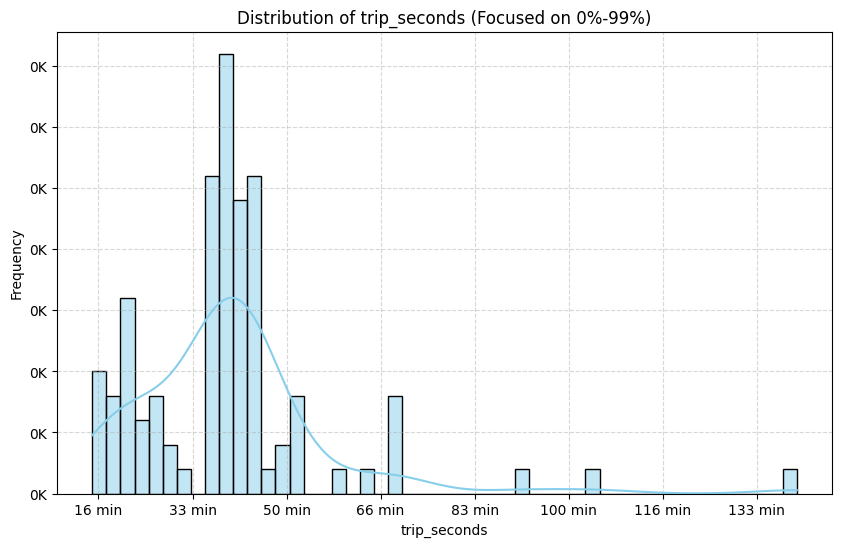

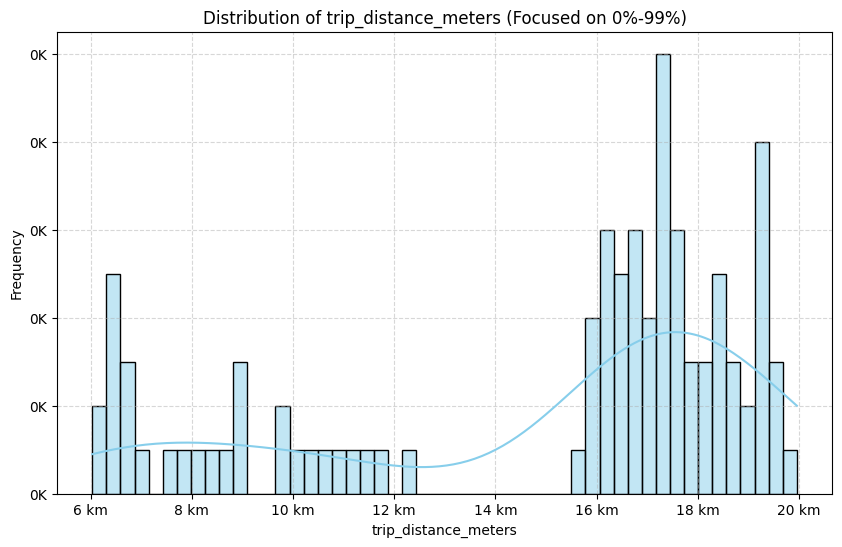

Sample size: 100


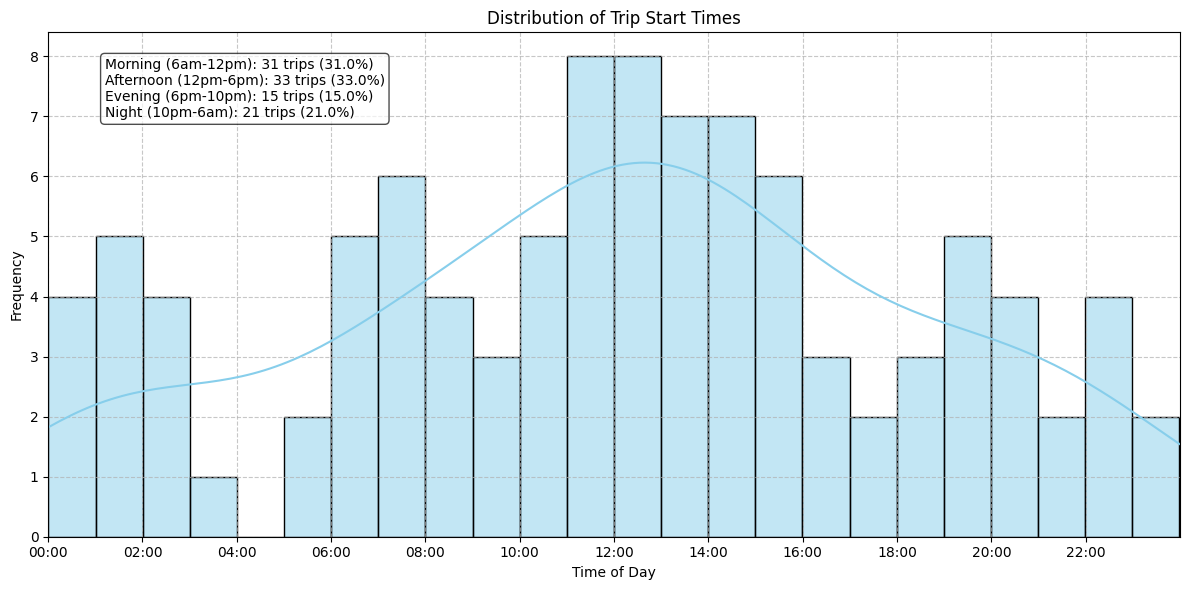

In [52]:
plot_distribution(sample_sf_100, "trip_seconds",x_factor=1/60,x_unit="min",lower_quantile=0.0, upper_quantile=0.99, bins=50)
plot_distribution(sample_sf_100, "trip_distance_meters",x_factor=1/1000, x_unit="km", lower_quantile=0.0, upper_quantile=0.99, bins=50)
plot_time_distribution(sample_sf_100, datetime_column='start_time', bins=24, kde=True)
print(f"Sample size: {len(sample_sf_100)}")

##### 1K san francisco 

In [261]:
## create samples with the true distance distribution
sample_sf_1k = create_targeted_sample(dataset_sf, "trip_distance_meters",
                       sample_size=1000, 
                       target_range_pct=0.7, 
                       range_tolerance=0.13, 
                       )
sample_sf_1k = normalize_sample_dates(sample_sf_1k)

sample_sf_1k.head()

Data after min/max filtering: 1302065 rows (originally 4090590)
Target range: 15808 - 20532
Value constraints: min=6000, max=25000
Available in-range rows: 160921
Available out-range rows: 1141144
Sampling 700 from range, 300 from normal distribution
✓ Successfully sampled 700 rows from target range
✓ Successfully sampled 300 rows for normal distribution

📊 Sample Statistics:
Total sample size: 1000
Actual mean: 17968.08 (target: 18170)
In target range: 700 (70.0%)
Standard deviation: 4116.48
Min value: 6040.265
Max value: 24945.0


,start_time,end_time,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_seconds,trip_distance_meters
0,2025-09-15 05:16:49.243+00,2025-09-15 06:02:01.824+00,37.789,-122.397,37.863,-122.234,2712.580615,19590.860
1,2025-09-15 14:27:12.243+00,2025-09-15 15:20:41.034+00,37.616,-122.384,37.777,-122.431,3208.790769,23174.600
2,2025-09-15 12:36:44.243+00,2025-09-15 13:27:51.988+00,37.789,-122.407,37.614,-122.389,3067.744431,22155.932
3,2025-09-15 10:56:26.243+00,2025-09-15 11:42:08.722+00,37.615,-122.390,37.733,-122.483,2742.478754,19806.791
4,2025-09-15 15:34:08.243+00,2025-09-15 16:16:27.739+00,37.753,-122.408,37.628,-122.400,2539.496077,18340.805


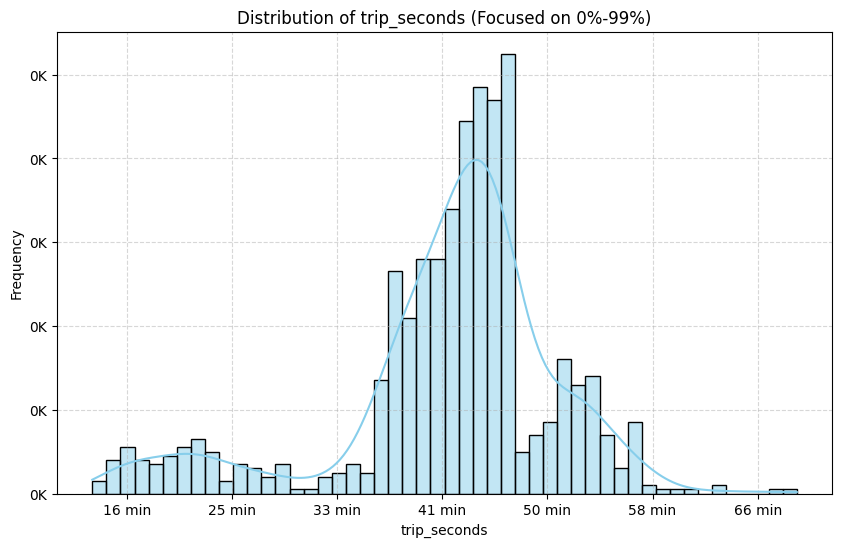

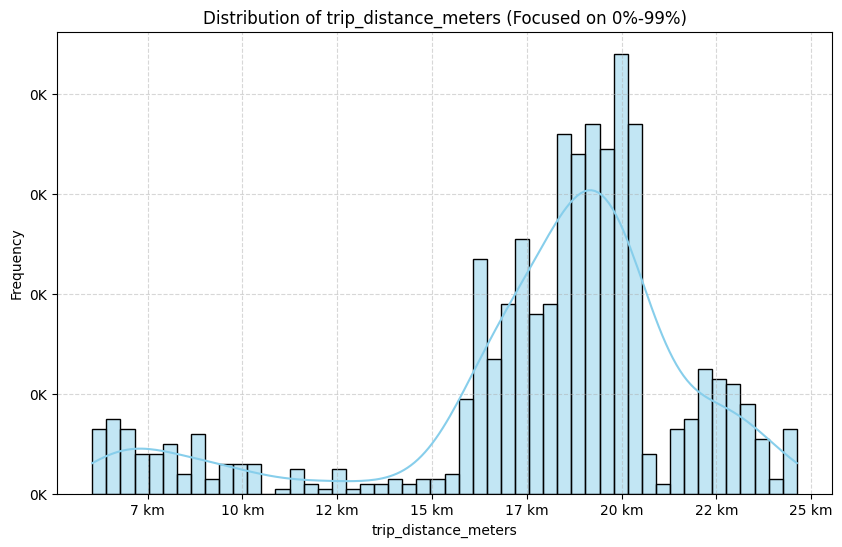

Sample size: 1000


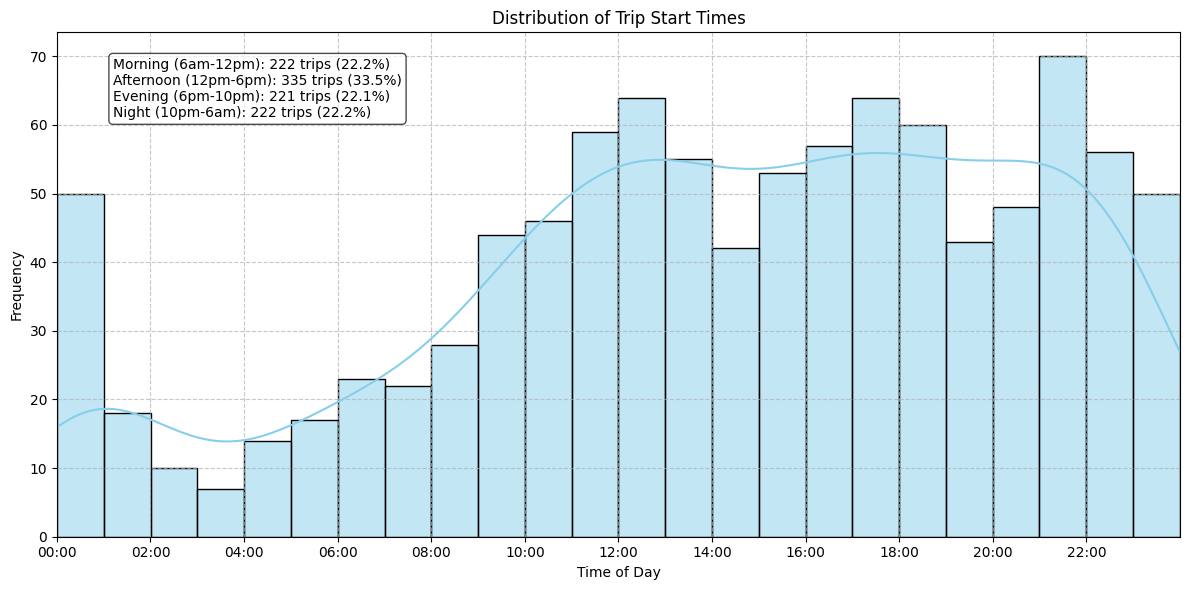

In [262]:
plot_distribution(sample_sf_1k, "trip_seconds",x_factor=1/60,x_unit="min",lower_quantile=0.0, upper_quantile=0.99, bins=50)
plot_distribution(sample_sf_1k, "trip_distance_meters",x_factor=1/1000, x_unit="km", lower_quantile=0.0, upper_quantile=0.99, bins=50)
plot_time_distribution(sample_sf_1k, datetime_column='start_time', bins=24, kde=True)
print(f"Sample size: {len(sample_sf_1k)}")


##### 10K san francisco 

In [291]:
sample_sf_10k = create_targeted_sample(dataset_sf, "trip_distance_meters",
                       sample_size=10000, 
                       target_range_pct=0.7, 
                       range_tolerance=0.13, 
                       )
sample_sf_10k = normalize_sample_dates(sample_sf_10k)

sample_sf_10k.head()

Data after min/max filtering: 1302065 rows (originally 4090590)
Target range: 15808 - 20532
Value constraints: min=6000, max=25000
Available in-range rows: 160921
Available out-range rows: 1141144
Sampling 7000 from range, 3000 from normal distribution
✓ Successfully sampled 7000 rows from target range
✓ Successfully sampled 3000 rows for normal distribution

📊 Sample Statistics:
Total sample size: 10000
Actual mean: 18000.87 (target: 18170)
In target range: 7000 (70.0%)
Standard deviation: 3989.75
Min value: 6000.263
Max value: 24971.682


C:\Users\mariam\AppData\Local\Temp\ipykernel_12920\1156179889.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
C:\Users\mariam\AppData\Local\Temp\ipykernel_12920\1156179889.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])


,start_time,end_time,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_seconds,trip_distance_meters
0,2025-09-15 16:47:27.243+00,2025-09-15 17:31:58.431+00,37.785,-122.404,37.741,-122.387,2671.187538,19291.910
1,2025-09-15 10:55:09.243+00,2025-09-15 11:36:22.720+00,37.615,-122.390,37.560,-122.273,2473.476923,17864.000
2,2025-09-15 12:58:06.243+00,2025-09-15 13:43:19.760+00,37.620,-122.399,37.748,-122.447,2713.516754,19597.621
3,2025-09-15 01:00:25.243+00,2025-09-15 01:43:42.895+00,37.723,-122.483,37.617,-122.382,2597.652277,18760.822
4,2025-09-15 23:43:11.243+00,2025-09-16 00:25:13.165+00,37.781,-122.400,37.617,-122.384,2521.921708,18213.879


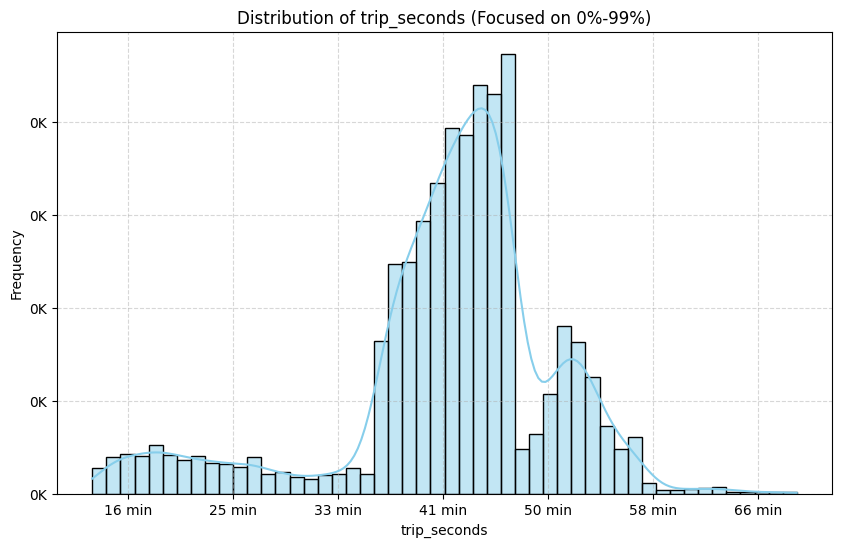

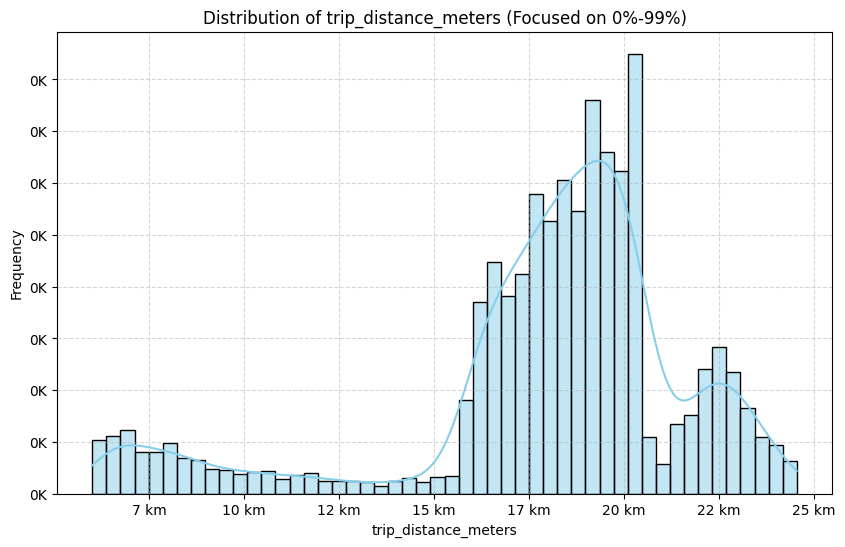

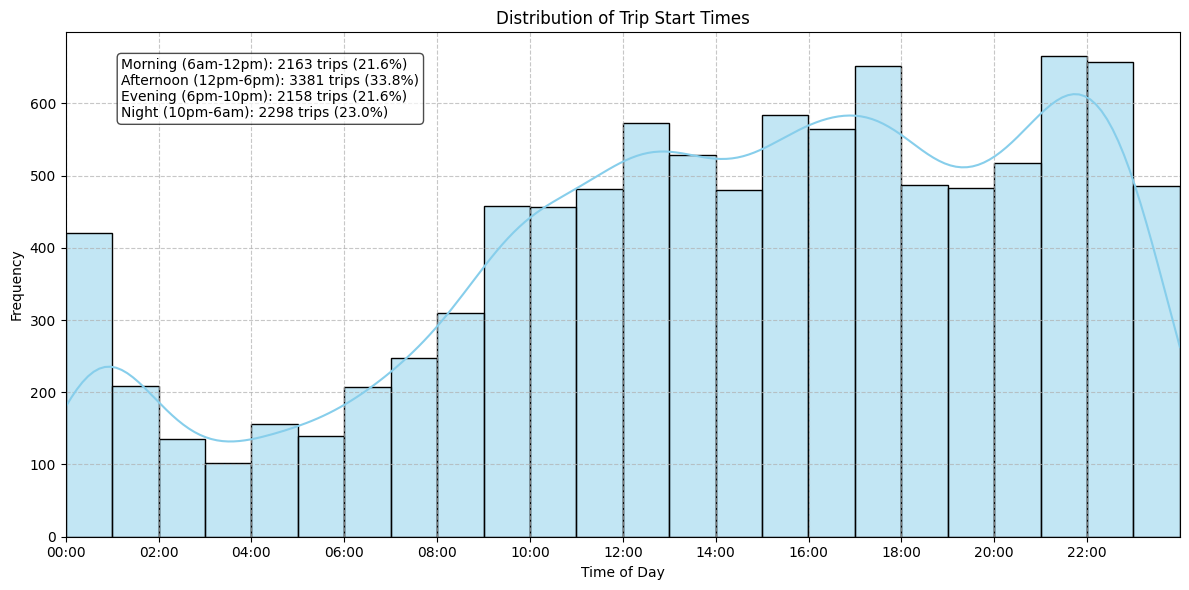

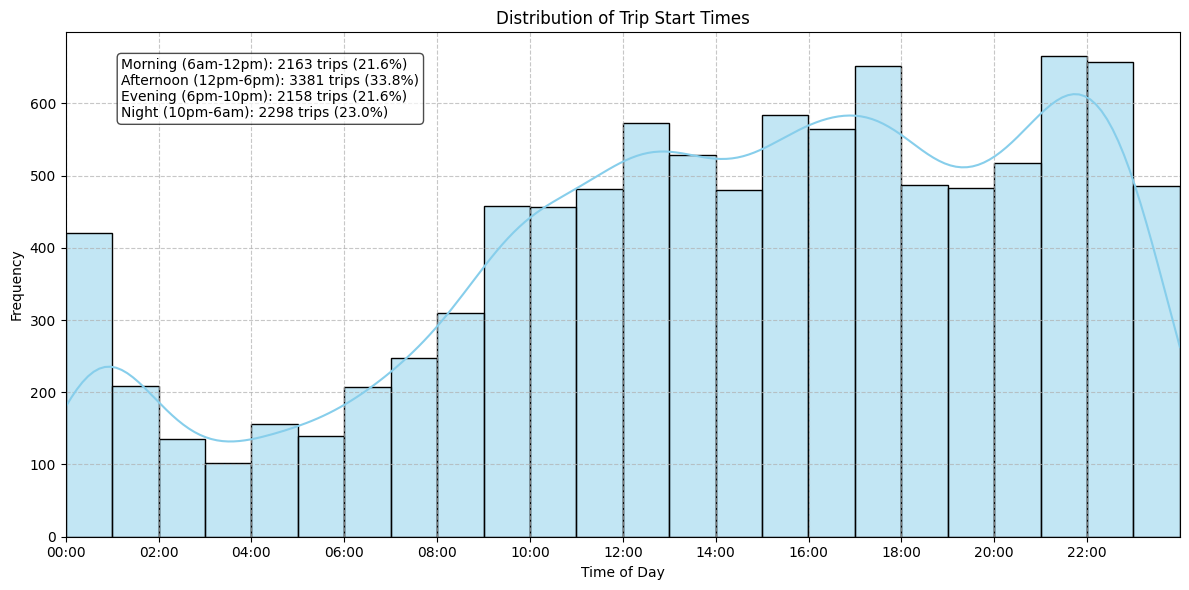

In [292]:
plot_distribution(sample_sf_10k, "trip_seconds",x_factor=1/60,x_unit="min",lower_quantile=0.0, upper_quantile=0.99, bins=50)
plot_distribution(sample_sf_10k, "trip_distance_meters",x_factor=1/1000, x_unit="km", lower_quantile=0.0, upper_quantile=0.99, bins=50)
plot_time_distribution(sample_sf_10k, datetime_column="start_time", bins=24, kde=True)

##### 20K san francisco 

In [ ]:
sample_sf_20k = create_targeted_sample(dataset_sf, "trip_distance_meters",
                       sample_size=20000, 
                       target_range_pct=0.7, 
                       range_tolerance=0.13, 
                       )
sample_sf_20k = normalize_sample_dates(sample_sf_20k, "start_time", "end_time")

sample_sf_20k.head()

In [ ]:
plot_distribution(sample_sf_20k, "trip_seconds",x_factor=1/60,x_unit="min",lower_quantile=0.0, upper_quantile=0.99, bins=50)
plot_distribution(sample_sf_20k, "trip_distance_meters",x_factor=1/1000, x_unit="km", lower_quantile=0.0, upper_quantile=0.99, bins=50)
plot_time_distribution(sample_sf_20k, datetime_column="start_time", bins=24, kde=True)  

##### 50K san francisco 

In [ ]:
sample_sf_50k = create_targeted_sample(dataset_sf, "trip_distance_meters",
                       sample_size=50000, 
                       target_range_pct=0.7, 
                       range_tolerance=0.13, 
                       )
sample_sf_50k = normalize_sample_dates(sample_sf_50k)

sample_sf_50k.head()

In [ ]:
plot_distribution(sample_sf_50k, "trip_seconds",x_factor=1/60,x_unit="min",lower_quantile=0.0, upper_quantile=0.99, bins=50)
plot_distribution(sample_sf_50k, "trip_distance_meters",x_factor=1/1000, x_unit="km", lower_quantile=0.0, upper_quantile=0.99, bins=50)
plot_time_distribution(sample_sf_50k, datetime_column="start_time", bins=24, kde=True)

### Matching Percentage Dataset Generation

#### Maximum Number of Requests per Driver Offer 

#### Number of Drivers to Riders

#### Driver Detour

#### Rider Walking Time

#### Rider Time Tolerance

## Write into Database

In [24]:
import os
from dotenv import load_dotenv
import psycopg2

def connect_to_database():
    """Connect to the database using environment variables"""
    # Load environment variables
    load_dotenv()
    
    # Database connection parameters
    db_params = {
        'host': os.getenv('DB_HOST', 'localhost'),
        'database': os.getenv('DB_NAME', 'matching_engine'),
        'user': os.getenv('DB_USER', 'postgres'),
        'password': os.getenv('DB_PASSWORD'),
        'port': os.getenv('DB_PORT', '5432')
    }
    
    # Check if password is available
    if not db_params['password']:
        raise ValueError("DB_PASSWORD environment variable is not set")
    
    # Connect to database and return connection and cursor
    conn = psycopg2.connect(**db_params)
    return conn

In [25]:
def insert_into_database(df, chunk_size=1000, dataset_id=None, rider_ratio=RIDER_RATIO):
    """Process and insert data into database tables"""
    conn = connect_to_database()
    cursor = conn.cursor()
    all_requests = []
    all_offers = []
    try:
        # Split data: rider_ratio% for rider requests, the rest for driver offers
        print(rider_ratio)
        split_point = int(len(df) * rider_ratio)
        rider_data = df.iloc[:split_point].reset_index(drop=True)
        driver_data = df.iloc[split_point:].reset_index(drop=True)
        
        print(f"Creating {len(rider_data)} rider requests and {len(driver_data)} driver offers")
        
        # Insert rider requests
        for chunk_start in range(0, len(rider_data), chunk_size):
            chunk_end = min(chunk_start + chunk_size, len(rider_data))
            chunk = rider_data.iloc[chunk_start:chunk_end]
            
            requests = create_rider_requests(chunk, chunk_start, dataset_id)
            all_requests.extend(requests)
            # SQL for inserting rider requests
            insert_rider_sql = """
            INSERT INTO rider_requests (
                id, user_id, 
                source_latitude, source_longitude, source_address,
                destination_latitude, destination_longitude, destination_address,
                earliest_departure_time, latest_arrival_time,
                max_walking_duration_minutes, number_of_riders,
                same_gender, user_gender, dataset_id
            ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            """
            
            execute_batch(cursor, insert_rider_sql, requests)
            conn.commit()
            print(f"Inserted {len(requests)} rider requests")
        
        # Insert driver offers
        for chunk_start in range(0, len(driver_data), chunk_size):
            chunk_end = min(chunk_start + chunk_size, len(driver_data))
            chunk = driver_data.iloc[chunk_start:chunk_end]
            
            offers = create_driver_offers(chunk, chunk_start, dataset_id)
            all_offers.extend(offers)
            # SQL for inserting driver offers
            # SQL for inserting driver offers
            insert_driver_sql = """
            INSERT INTO driver_offers (
                id, user_id,
                source_latitude, source_longitude, source_address,
                destination_latitude, destination_longitude, destination_address,
                departure_time, max_estimated_arrival_time, estimated_arrival_time,
                detour_duration_minutes, capacity, current_number_of_requests,
                same_gender, user_gender, dataset_id
            ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            """
            
            execute_batch(cursor, insert_driver_sql, offers)
            conn.commit()
            print(f"Inserted {len(offers)} driver offers")
        
        print("Data import completed successfully")
        
    except Exception as e:
        conn.rollback()
        print(f"Error: {e}")
        
    finally:
        cursor.close()
        conn.close()

In [250]:
conn = connect_to_database()
cursor = conn.cursor()
cursor.execute("""
    INSERT INTO rider_requests (
        id, user_id, 
        source_latitude, source_longitude, source_address,
        destination_latitude, destination_longitude, destination_address,
        earliest_departure_time, latest_arrival_time,
        max_walking_duration_minutes, number_of_riders,
        same_gender, user_gender, dataset_id
    ) VALUES (
        %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s
    )
""", (
    'dssf_1k-req-000000', 'dssf_1k-user-3137', 37.616, -122.384, None, 37.735, -122.458, None, '2025-09-15 00:21:13.243+00', '2025-09-15 01:33:23.259+00', 10, 1, True, 'male', 'sf_1k'
))

conn.commit()
cursor.close()
conn.close()

In [263]:
sample_sf_1k[(sample_sf_1k['pickup_latitude'] > 90) | 
             (sample_sf_1k['pickup_latitude'] < -90) |
             (sample_sf_1k['dropoff_latitude'] < -90) | 
             (sample_sf_1k['dropoff_latitude'] > 90)]

,start_time,end_time,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_seconds,trip_distance_meters


In [40]:
def is_in_sf(lat, lng):
    """Check if coordinates are within San Francisco city limits (approximate)"""
    return (37.7083 <= lat <= 37.8324 and 
            -122.5136 <= lng <= -122.3549)

In [44]:
dataset_sf['valid_coordinates'] = dataset_sf.apply(
    lambda row: is_in_sf(row['pickup_latitude'], row['pickup_longitude']) and
                is_in_sf(row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
print(f"Valid coordinates in sample_sf_100: {dataset_sf['valid_coordinates'].sum()} out of {len(dataset_sf)}")

Valid coordinates in sample_sf_100: 2696292 out of 4090590


0.6591450133110383

In [42]:
print(f"Valid coordinates in sample_sf_100: {sample_sf_100['valid_coordinates'].sum()} out of {len(sample_sf_100)}")

Valid coordinates in sample_sf_100: 24 out of 100


In [37]:
insert_into_database(sample_sf_10, dataset_id="sf_10")

0.75
Creating 7 rider requests and 3 driver offers
Error: duplicate key value violates unique constraint "rider_requests_pkey"
DETAIL:  Key (id)=(dssf_10-req-000000) already exists.



In [53]:
insert_into_database(sample_sf_100, dataset_id="sf_100")

0.75
Creating 75 rider requests and 25 driver offers
Inserted 75 rider requests
Inserted 25 driver offers
Data import completed successfully


In [286]:
insert_into_database(sample_sf_1k, dataset_id="sf_1k")

0.75
Creating 750 rider requests and 250 driver offers
Inserted 750 rider requests
Inserted 250 driver offers
Data import completed successfully


In [293]:
insert_into_database(sample_sf_10k, dataset_id="sf_10k")


0.75
Creating 7500 rider requests and 2500 driver offers
Inserted 1000 rider requests
Inserted 1000 rider requests
Inserted 1000 rider requests
Inserted 1000 rider requests
Inserted 1000 rider requests
Inserted 1000 rider requests
Inserted 1000 rider requests
Inserted 500 rider requests
Inserted 1000 driver offers
Inserted 1000 driver offers
Inserted 500 driver offers
Data import completed successfully


## checking the data distribution in the database after inserting it

In [ ]:
# Query the database to get the data back
def analyze_database_distribution(dataset_id):
    conn = connect_to_database()
    cursor = conn.cursor()
    
    # Get rider requests
    cursor.execute("""
        SELECT max_walking_duration_minutes, number_of_riders, same_gender, user_gender
        FROM rider_requests 
        WHERE dataset_id = %s
    """, (dataset_id,))
    rider_data = cursor.fetchall()
    
    # Get driver offers
    cursor.execute("""
        SELECT detour_duration_minutes, capacity, same_gender, user_gender
        FROM driver_offers
        WHERE dataset_id = %s
    """, (dataset_id,))
    driver_data = cursor.fetchall()
    
    cursor.close()
    conn.close()
    
    # Convert to DataFrame for analysis
    rider_df = pd.DataFrame(rider_data, columns=['max_walking_duration_minutes', 'number_of_riders', 'same_gender', 'user_gender'])
    driver_df = pd.DataFrame(driver_data, columns=['detour_duration_minutes', 'capacity', 'same_gender', 'user_gender'])
    
    # Analyze distributions
    print(f"=== Distribution Analysis for Dataset '{dataset_id}' ===")
    
    print("\nRider requests count", rider_df.shape[0])
    print("\nDriver offers count", driver_df.shape[0])
    
    print("\nRider walking duration distribution:")
    print(rider_df['max_walking_duration_minutes'].value_counts(normalize=True).sort_index() * 100)
    
    print("\nRider count distribution:")
    print(rider_df['number_of_riders'].value_counts(normalize=True).sort_index() * 100)
    
    print("\nDriver capacity distribution:")
    print(driver_df['capacity'].value_counts(normalize=True).sort_index() * 100)
    
    print("\nDriver detour minutes distribution:")
    print(driver_df['detour_duration_minutes'].value_counts(normalize=True).sort_index() * 100)
    
    # Check gender distributions
    print("\nRider gender distribution:")
    print(rider_df['user_gender'].value_counts(normalize=True) * 100)
    
    print("\nDriver gender distribution:")
    print(driver_df['user_gender'].value_counts(normalize=True) * 100)
    
    # Same gender preference
    print("\nRider same gender preference:")
    print(rider_df.groupby(['user_gender', 'same_gender']).size().unstack().apply(lambda x: x/x.sum() * 100, axis=1))
    
    print("\nDriver same gender preference:")
    print(driver_df.groupby(['user_gender', 'same_gender']).size().unstack().apply(lambda x: x/x.sum() * 100, axis=1))
    
    return rider_df, driver_df


In [ ]:
# Run the analysis after inserting data
rider_df, driver_df = analyze_database_distribution("sf_1k")

In [299]:
rider_df, driver_df = analyze_database_distribution("sf_10k")

=== Distribution Analysis for Dataset 'sf_10k' ===

 Rider requests count 7500

Driver offers count 2500

Rider walking duration distribution:
max_walking_duration_minutes
5     44.640000
10    36.546667
15    10.680000
20     4.320000
25     3.813333
Name: proportion, dtype: float64

Rider count distribution:
number_of_riders
1    62.146667
2    32.000000
3     5.853333
Name: proportion, dtype: float64

Driver capacity distribution:
capacity
1    19.76
2    30.92
3    49.32
Name: proportion, dtype: float64

Driver detour minutes distribution:
detour_duration_minutes
0     28.92
10    37.12
15    20.76
20     9.48
25     3.72
Name: proportion, dtype: float64

Rider gender distribution:
user_gender
male      52.346667
female    47.653333
Name: proportion, dtype: float64

Driver gender distribution:
user_gender
male      62.92
female    37.08
Name: proportion, dtype: float64

Rider same gender preference:
same_gender      False      True 
user_gender                      
female        7